In [2]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')


In [3]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDatesDS):
    iTimes = []
    
    for iTime in range(len(matchDatesDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDatesDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==matchDatesDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==matchDatesDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)


In [4]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data 

In [4]:
# saveDir = '/glade/u/home/mdfowler/Analysis/ProcessingData/processed_files/'

# ## One at a time
# realSfcHTG_thlp2    = pickle.load( open( saveDir+"realSfc_HTG_thlp2only_relaxTlongTau_freeSfcT.p", "rb" ) )
# realSfcHTG_rtp2     = pickle.load( open( saveDir+"realSfc_HTG_rtp2only_relaxTlongTau_freeSfcT.p", "rb" ) )
# realSfcHTG_rtpthlp  = pickle.load( open( saveDir+"realSfc_HTG_rtpthlponly_relaxTlongTau_freeSfcT.p", "rb" ) )

# ## One at a time*2
# realSfcHTG2_thlp2    = pickle.load( open( saveDir+"realSfc_HTG_thlp2only_relaxTlongTau_freeSfcT_multiplier2p0.p", "rb" ) )
# realSfcHTG2_rtp2     = pickle.load( open( saveDir+"realSfc_HTG_rtp2only_relaxTlongTau_freeSfcT_multiplier2p0.p", "rb" ) )
# realSfcHTG2_rtpthlp  = pickle.load( open( saveDir+"realSfc_HTG_rtpthlponly_relaxTlongTau_freeSfcT_multiplier2p0.p", "rb" ) )

# ## Combine into one array
# realSfcHTG_thlp2   = realSfcHTG_thlp2.assign_coords({"case": 'HTG_thlp2'})
# realSfcHTG_rtp2    = realSfcHTG_rtp2.assign_coords({"case": 'HTG_rtp2'})
# realSfcHTG_rtpthlp = realSfcHTG_rtpthlp.assign_coords({"case": 'HTG_rtpthlp'})

# realSfcHTG2_thlp2   = realSfcHTG2_thlp2.assign_coords({"case": 'HTG_thlp2*2'})
# realSfcHTG2_rtp2    = realSfcHTG2_rtp2.assign_coords({"case": 'HTG_rtp2*2'})
# realSfcHTG2_rtpthlp = realSfcHTG2_rtpthlp.assign_coords({"case": 'HTG_rtpthlp*2'})


# realSfc_oneHTG = xr.concat([realSfcHTG_thlp2, 
#                               realSfcHTG_rtp2,
#                               realSfcHTG_rtpthlp,                              
#                               realSfcHTG2_thlp2, 
#                               realSfcHTG2_rtp2,
#                               realSfcHTG2_rtpthlp,
#                                ], "case")

# print('Done combining cases') 

# del realSfcHTG_thlp2
# del realSfcHTG_rtp2
# del realSfcHTG_rtpthlp
# del realSfcHTG2_thlp2
# del realSfcHTG2_rtp2
# del realSfcHTG2_rtpthlp


Done combining cases


In [5]:
# ## Read in the full HTG and the HMG cases too 
# realSfcHMG          = pickle.load( open( saveDir+"realSfc_HMG_relaxTlongTau_freeSfcT.p", "rb" ) )
# realSfcHTG          = pickle.load( open( saveDir+"realSfc_HTG_relaxTlongTau_freeSfcT.p", "rb" ) )

# ## Combine into one array
# realSfcHMG   = realSfcHMG.assign_coords({"case": 'HMG'})
# realSfcHTG   = realSfcHTG.assign_coords({"case": 'HTG'})

# realSfc_allCases = xr.concat([realSfcHMG, 
#                              realSfcHTG,
#                              ], "case")

# del realSfcHMG
# del realSfcHTG

In [6]:
# ## Add extra vars?
# caseNameHTG    = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_'
# caseNameHMG    = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_'

# yearStrings  = np.asarray(['2015','2016','2017','2018'])

# fileCount=0
# for iYr in range(len(yearStrings)): 
#     fileName_atm_HMG   = saveDir+caseNameHMG+yearStrings[iYr]+'jja_relaxTlongTau_freeSfcT.cam.h0.ExtraVars_v2.nc'
#     fileName_atm_HTG   = saveDir+caseNameHTG+yearStrings[iYr]+'jja_relaxTlongTau_freeSfcT.cam.h0.ExtraVars_v2.nc'


#     with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
#         HMG_camDS = cesm_correct_time(HMG_camDS)
#         HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()  
#     with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
#         HTG_camDS = cesm_correct_time(HTG_camDS)
#         HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
        
#     # Discard first two days 
#     iTimeStart     = np.where(HTG_camDS.time.values >= (HTG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
#     timeArr        = np.arange(iTimeStart[0], len(HTG_camDS.time.values))

#     HMG_camDS      = HMG_camDS.isel(time=timeArr)
#     HTG_camDS      = HTG_camDS.isel(time=timeArr)


#     if fileCount==0:
#         HMGcamDS_realSfcExtra   = HMG_camDS
#         HTGcamDS_realSfcExtra   = HTG_camDS

#     else: 
#         HMGcamDS_realSfcExtra    = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
#         HTGcamDS_realSfcExtra    = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')

        
#     fileCount = fileCount+1
#     print('Done with file %i of %i '% (fileCount,len(yearStrings)))

    
# ## Convert to local time 
# HMGcamDS_realSfcExtraLocal      = HMGcamDS_realSfcExtra.copy(deep=True)
# HTGcamDS_realSfcExtraLocal      = HTGcamDS_realSfcExtra.copy(deep=True)


# # Confirmed that all the times are identical, so using the same local time arrays
# localTimes = HMGcamDS_realSfcExtra['time'].values - np.timedelta64(5,'h')

# # Replace time dimension with local time
# HMGcamDS_realSfcExtraLocal      = HMGcamDS_realSfcExtraLocal.assign_coords({"time": localTimes})
# HTGcamDS_realSfcExtraLocal      = HTGcamDS_realSfcExtraLocal.assign_coords({"time": localTimes})


# ## Combine into single DS with case dimension
# HMGcamDS_realSfcExtraLocal    = HMGcamDS_realSfcExtraLocal.assign_coords({"case": 'HMG'})
# HTGcamDS_realSfcExtraLocal    = HTGcamDS_realSfcExtraLocal.assign_coords({"case": 'HTG'})


# realSfc_allCasesExtra         = xr.concat([HMGcamDS_realSfcExtraLocal,
#                                            HTGcamDS_realSfcExtraLocal, 
#                                           ], "case")


# # Merge into larger dataset
# realSfc_allCases = xr.merge([realSfc_allCases, realSfc_allCasesExtra])
# print('Everything merged in successfully.')

# del realSfc_allCasesExtra 
# del HMGcamDS_realSfcExtraLocal
# del HTGcamDS_realSfcExtraLocal
# del HTG_camDS
# del HMG_camDS



Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 
Everything merged in successfully.


In [7]:
# ## Combine everything into just one DS 

# realSfc_allCases = xr.merge([realSfc_allCases, realSfc_oneHTG])
# del realSfc_oneHTG


In [5]:
## It can actually take **quite** some time (and memory) to read in *all* the cases we have outlined above and combine them.
#   So let's go ahead and save that out into its own .p file, and that can be re-loaded in the future. 

saveDir = '/glade/work/mdfowler/CLASP/'
# pickle.dump( realSfc_allCases,   open( saveDir+"realSfc_allCases_oneHTGandMult2p0.p", "wb" ) )
# print('Saved full DS to pickle')

realSfc_allCases    = pickle.load( open( saveDir+"realSfc_allCases_oneHTGandMult2p0.p", "rb" ) )
print('Read in all cases') 


Read in all cases


In [8]:
# dropVars         = np.asarray(['ntrk','ntrn','ntrm','hyam','hybm','hyai','hybi','datesec','date','time_bnds','date_written','time_written','gw','co2vmr','ch4vmr','n2ovmr','f11vmr','f12vmr','sol_tsi','nsteph','U','V','T','Q','TKE','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLOUD','CLOUDFRAC_CLUBB','CLOUDCOVER_CLUBB','UPWP_CLUBB','VPWP_CLUBB','RCM_CLUBB','RTP2_CLUBB','THLP2_CLUBB','RTPTHLP_CLUBB','WP2RTP_CLUBB','QRS','QRL','DCQ'])
# realSfc_allCases = realSfc_allCases.drop(dropVars)

In [5]:
# dropVars         = np.asarray(['CLOUDFRAC_CLUBB','CLOUDCOVER_CLUBB','RTP2_CLUBB','THLP2_CLUBB','RTPTHLP_CLUBB'])
# realSfc_allCases = realSfc_allCases.drop(dropVars)

In [6]:
# pickle.dump( realSfc_allCases,   open( saveDir+"realSfc_allCases_oneHTGandMult2p0.p", "wb" ) )
# print('Saved full DS to pickle')

Saved full DS to pickle


In [6]:
## Add in HTG*2? 
saveDir = '/glade/work/mdfowler/CLASP/'
realSfc_HTG2    = pickle.load( open( saveDir+"realSfc_HTG_relaxTlongTau_freeSfcT_multiplier2p0.p", "rb" ) )
realSfc_HTG2  = realSfc_HTG2.assign_coords({"case": 'HTG*2'})

list1 = set(realSfc_allCases.keys())
list2 = set(realSfc_HTG2.keys())
sameVarsCAM = list( list1 & list2 )

realSfc_allCases = xr.concat([realSfc_allCases[sameVarsCAM], realSfc_HTG2[sameVarsCAM] ], "case")
del realSfc_HTG2


In [7]:
## First day of each run 06/02 doesn't start until 6p. So drop 06/02 
## And last day of each run 8/28 only goes until about 6p, so let's drop 8/28 too. 

iDropJune      = np.where( (realSfc_allCases['time.month']==6) & (realSfc_allCases['time.day']==2))[0]
iDropAug       = np.where( (realSfc_allCases['time.month']==8) & (realSfc_allCases['time.day']==28))[0]
allTimeIndices = np.arange(0,len(realSfc_allCases.time.values))
keepIndices    = np.delete(allTimeIndices, np.append(iDropJune, iDropAug))

## Now limit to those days:
realSfc_allCases        = realSfc_allCases.isel(time=keepIndices)


In [8]:
## Add in EF  
realSfc_allCases['EF']  = ( ('case','time','lat,','lon'),
                   (realSfc_allCases['LHFLX']/(realSfc_allCases['LHFLX']+realSfc_allCases['SHFLX'])) )                              
realSfc_allCases['EF'].attrs['units']   = '-'
realSfc_allCases['EF'].attrs['long_name']   = 'Evaporative Fraction'

## Add in Bowen Ratio  
realSfc_allCases['BowenRatio']  = ( ('case','time','lat,','lon'),
                   (realSfc_allCases['SHFLX']/(realSfc_allCases['LHFLX'])) )
realSfc_allCases['BowenRatio'].attrs['units']   = '-'
realSfc_allCases['BowenRatio'].attrs['long_name']   = 'Bowen Ratio'


In [9]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([realSfc_allCases['time.year'].values,
                                                                realSfc_allCases['time.month'].values, 
                                                                realSfc_allCases['time.day'].values])

realSfc_allCases.coords['year_month_day']         = ('time', month_day_idx)


## Identify sensitive days

In [10]:
realSfc_allCases.case.values

array(['HMG', 'HTG', 'HTG_rtp2', 'HTG_rtp2*2', 'HTG_rtpthlp',
       'HTG_rtpthlp*2', 'HTG_thlp2', 'HTG_thlp2*2', 'HTG*2'], dtype=object)

In [11]:
## Variable name to base selection on 
varSel  = 'PBLH'

## Hours to base selection on 
startHr = 12
endHr   = 18


In [12]:
## Select the variable we're looking at using for identifyign sensitve days 

if len(np.shape(realSfc_allCases[varSel]))==5:
    if np.shape(realSfc_allCases[varSel])[2]==65:
        real_var = realSfc_allCases[varSel].isel(ilev=-1)
    elif np.shape(realSfc_allCases[varSel])[2]==64:
        real_var = realSfc_allCases[varSel].isel(lev=-1)
else:
    real_var = realSfc_allCases[varSel]

# Select those hours
iHours_real = np.where( (real_var['time.hour']>=startHr) & (real_var['time.hour']<=endHr) )[0]
real_var_selTime = real_var.isel(time=iHours_real)

# For each date, get the mean value over the selected time period 
real_var_dayMean = real_var_selTime.groupby('year_month_day').mean(dim='time')


In [13]:
## Get list of dates in string form
strDates = []

for iDate in range(len(real_var_dayMean.year_month_day.values)):
    yr_sel  = real_var_dayMean.year_month_day_level_0[iDate]
    mon_sel = real_var_dayMean.year_month_day_level_1[iDate]
    day_sel = real_var_dayMean.year_month_day_level_2[iDate]
    
    strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))

    
# Get year delineation 
yrStart =[]

for iDate in range(len(strDates)-1):
    if strDates[iDate].year==(strDates[iDate+1].year)-1:
        
        yrStart = np.append(yrStart, iDate+1)


In [14]:
def plotPDFS_distVar(distVar, logScaleBinary):
    #No filtering of days based on above condition (i.e., precip amount)
    if len(np.shape(realSfc_allCases[distVar]))==5:
        if distVar=='WP3_CLUBB':
            levSel=-2
        else: 
            levSel=-1
        
        if np.shape(realSfc_allCases[distVar])[2]==65:
            real_var = realSfc_allCases[distVar].isel(ilev=levSel)
        elif np.shape(realSfc_allCases[distVar])[2]==64:
            real_var = realSfc_allCases[distVar].isel(lev=levSel)        
    else:
        real_var = realSfc_allCases[distVar]

    # Select those hours
    iHours_real = np.where( (real_var['time.hour']>=startHr) & (real_var['time.hour']<=endHr) )[0]
    real_var_selTime = real_var.isel(time=iHours_real)

    # For each date, get the mean value over the selected time period 
    real_var_dayMean = real_var_selTime.groupby('year_month_day').mean(dim='time')

    # Define dataframe
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0])),   'case': 'HMG'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG')[0])),   'case': 'HTG'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_thlp2')[0])),   'case': 'HTG_thlp2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtp2')[0])),    'case': 'HTG_rtp2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtpthlp')[0])), 'case': 'HTG_rtpthlp'}),
    ])

    # Make plot 
    g = sns.displot(dfReal, x=varSel, hue='case', kind='kde', height=6, cut=0, 
                    palette=['black','firebrick','darkorange','dodgerblue','mediumorchid'])


    g.ax.set_title("Afternoon Mean "+distVar+" (hr"+str(startHr)+"-hr"+str(endHr)+")", fontsize=16 ) 
    g.ax.set_xlabel(distVar,fontsize=14)
    g.ax.set_ylabel('Density',fontsize=14)
    g.ax.tick_params(axis='both', labelsize= 12)
    plt.setp(g._legend.get_title(), fontsize=12)
    plt.setp(g._legend.get_texts(), fontsize=12)
    
    if logScaleBinary==1:
        g.ax.set_xscale('log')
    
    return plt
    

In [15]:
def plotPDFS_distVar_mult2(distVar, logScaleBinary):
    #No filtering of days based on above condition (i.e., precip amount)
    if len(np.shape(realSfc_allCases[distVar]))==5:
        if distVar=='WP3_CLUBB':
            levSel=-2
        else: 
            levSel=-1
        
        if np.shape(realSfc_allCases[distVar])[2]==65:
            real_var = realSfc_allCases[distVar].isel(ilev=levSel)
        elif np.shape(realSfc_allCases[distVar])[2]==64:
            real_var = realSfc_allCases[distVar].isel(lev=levSel)        
    else:
        real_var = realSfc_allCases[distVar]

    # Select those hours
    iHours_real = np.where( (real_var['time.hour']>=startHr) & (real_var['time.hour']<=endHr) )[0]
    real_var_selTime = real_var.isel(time=iHours_real)

    # For each date, get the mean value over the selected time period 
    real_var_dayMean = real_var_selTime.groupby('year_month_day').mean(dim='time')

    # Define dataframe
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0])),   'case': 'HMG'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG*2')[0])),   'case': 'HTG*2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_thlp2*2')[0])),   'case': 'HTG_thlp2*2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtp2*2')[0])),    'case': 'HTG_rtp2*2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtpthlp*2')[0])), 'case': 'HTG_rtpthlp*2'}),
    ])

    # Make plot 
    g = sns.displot(dfReal, x=varSel, hue='case', kind='kde', height=6, cut=0, 
                    palette=['black','firebrick','darkorange','dodgerblue','mediumorchid'])


    g.ax.set_title("Afternoon Mean "+distVar+" (hr"+str(startHr)+"-hr"+str(endHr)+")", fontsize=16 ) 
    g.ax.set_xlabel(distVar,fontsize=14)
    g.ax.set_ylabel('Density',fontsize=14)
    g.ax.tick_params(axis='both', labelsize= 12)
    plt.setp(g._legend.get_title(), fontsize=12)
    plt.setp(g._legend.get_texts(), fontsize=12)
    
    if logScaleBinary==1:
        g.ax.set_xscale('log')
    
    return plt
    

In [16]:
def plotPDFS_distVarRows(distVar, logScaleBinary):
    #No filtering of days based on above condition (i.e., precip amount)
    if len(np.shape(realSfc_allCases[distVar]))==5:
        if distVar=='WP3_CLUBB':
            levSel=-2
        else: 
            levSel=-1
        
        if np.shape(realSfc_allCases[distVar])[2]==65:
            real_var = realSfc_allCases[distVar].isel(ilev=levSel)
        elif np.shape(realSfc_allCases[distVar])[2]==64:
            real_var = realSfc_allCases[distVar].isel(lev=levSel)        
    else:
        real_var = realSfc_allCases[distVar]

    # Select those hours
    iHours_real = np.where( (real_var['time.hour']>=startHr) & (real_var['time.hour']<=endHr) )[0]
    real_var_selTime = real_var.isel(time=iHours_real)

    # For each date, get the mean value over the selected time period 
    real_var_dayMean = real_var_selTime.groupby('year_month_day').mean(dim='time')

    # Define dataframe
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0])),   'case': 'HMG'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG')[0])),   'case': 'HTG'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_thlp2')[0])),   'case': 'HTG_thlp2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtp2')[0])),    'case': 'HTG_rtp2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtpthlp')[0])), 'case': 'HTG_rtpthlp'}),

         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_thlp2*2')[0])),   'case': 'HTG_thlp2*2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtp2*2')[0])),    'case': 'HTG_rtp2*2'}),
         pd.DataFrame.from_dict({varSel: np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtpthlp*2')[0])), 'case': 'HTG_rtpthlp*2'}),

    ])

    # Make plot 
    g = sns.displot(dfReal, x=varSel, 
                    row='case',
                    kind='kde', height=6, cut=0)


#     g.ax.set_title("Afternoon Mean "+distVar+" (hr"+str(startHr)+"-hr"+str(endHr)+")", fontsize=16 ) 
#     g.ax.set_xlabel(distVar,fontsize=14)
#     g.ax.set_ylabel('Density',fontsize=14)
#     g.ax.tick_params(axis='both', labelsize= 12)
#     plt.setp(g._legend.get_title(), fontsize=12)
#     plt.setp(g._legend.get_texts(), fontsize=12)
    
#     if logScaleBinary==1:
#         g.ax.set_xscale('log')
    
    return plt
    

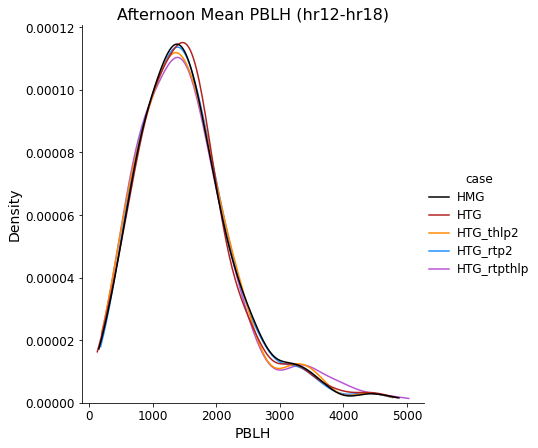

In [17]:
startHr = 12
endHr   = 18

distVar    = 'PBLH'
pltDistVar = plotPDFS_distVar(distVar,0)



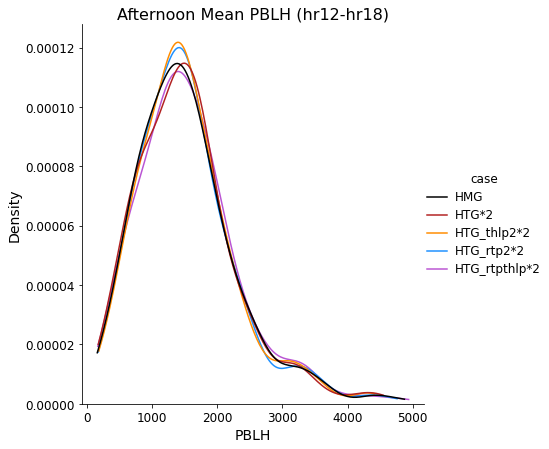

In [22]:
startHr = 12
endHr   = 18

distVar    = 'PBLH'
pltDistVar = plotPDFS_distVar_mult2(distVar,0)



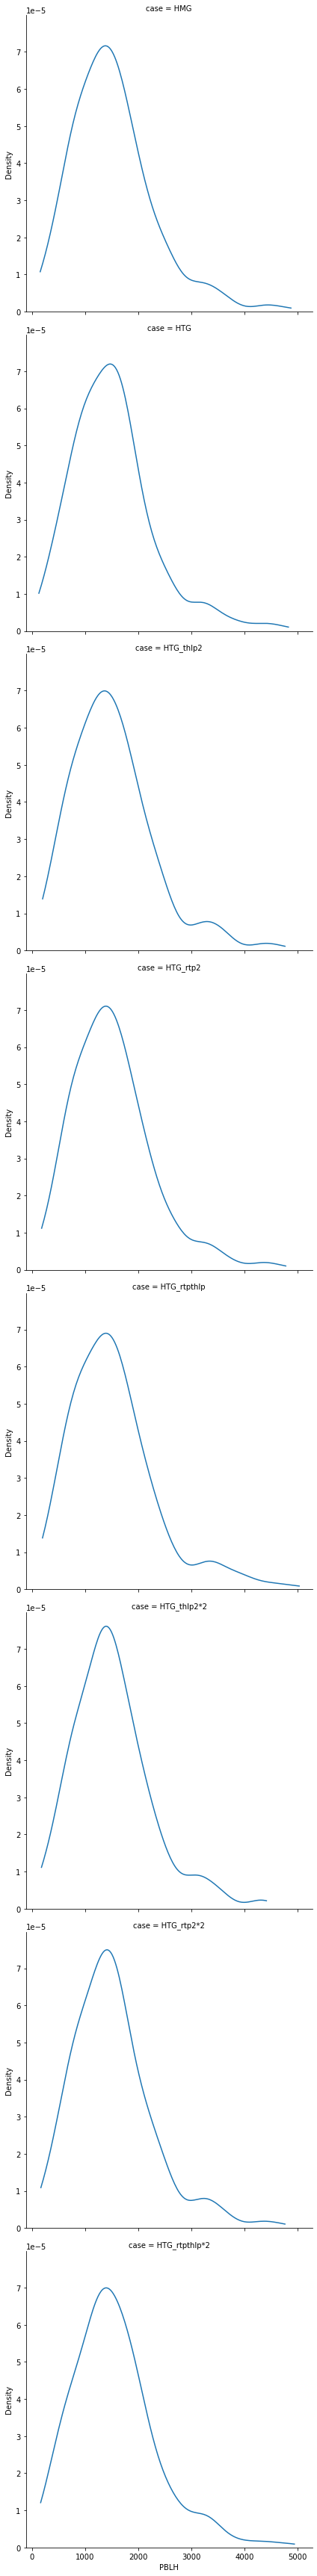

In [18]:
startHr = 12
endHr   = 18

distVar    = 'PBLH'
pltDistVar = plotPDFS_distVarRows(distVar,0)



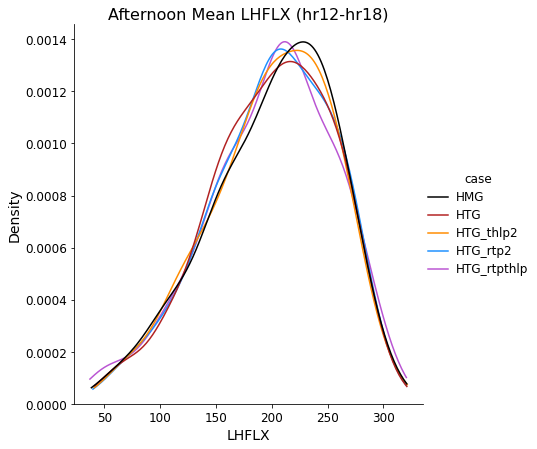

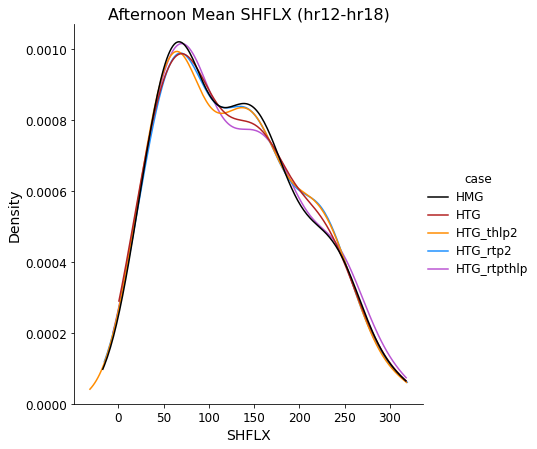

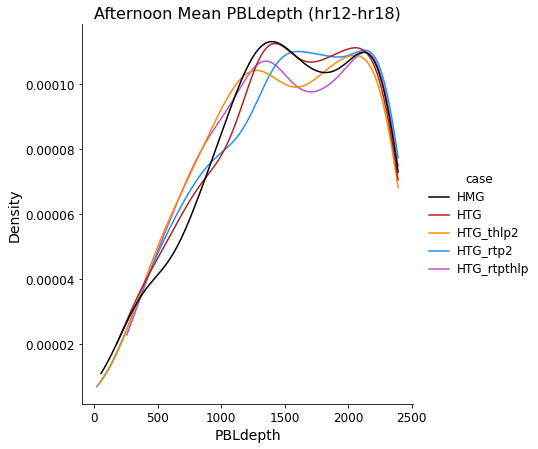

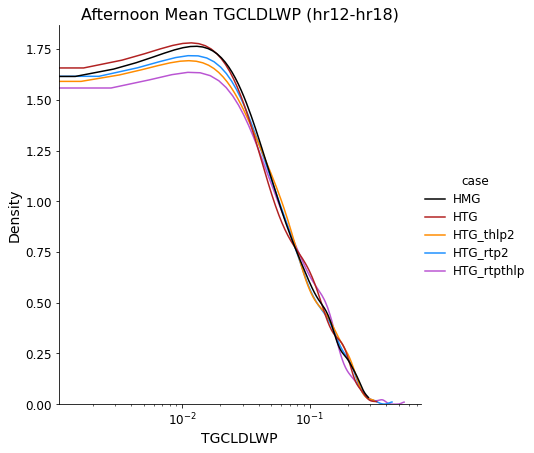

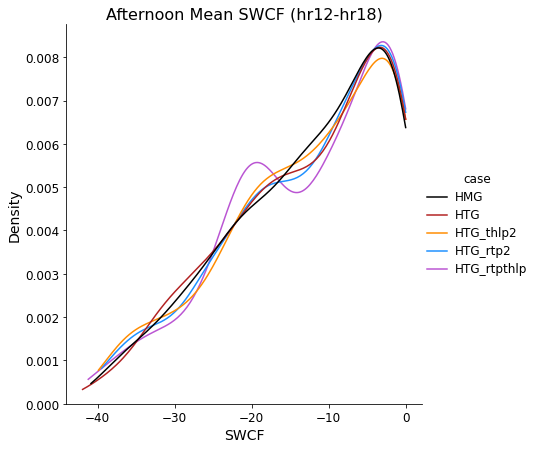

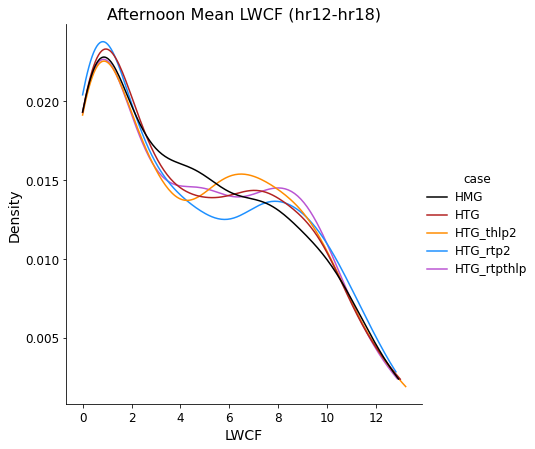

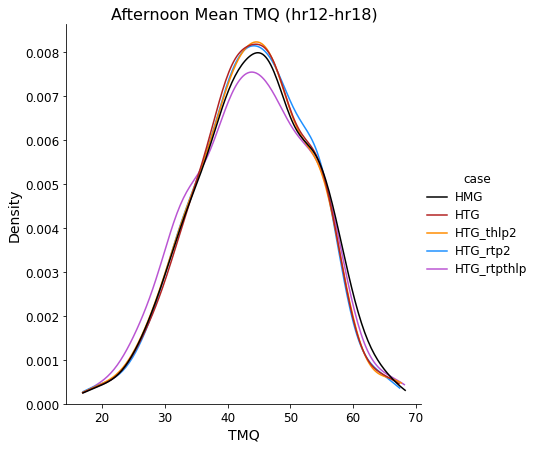

In [19]:
pltDistVar = plotPDFS_distVar('LHFLX',0)
pltDistVar = plotPDFS_distVar('SHFLX',0)

pltDistVar = plotPDFS_distVar('PBLdepth',0)
pltDistVar = plotPDFS_distVar('TGCLDLWP',1)
pltDistVar = plotPDFS_distVar('SWCF',0)
pltDistVar = plotPDFS_distVar('LWCF',0)
pltDistVar = plotPDFS_distVar('TMQ',0)


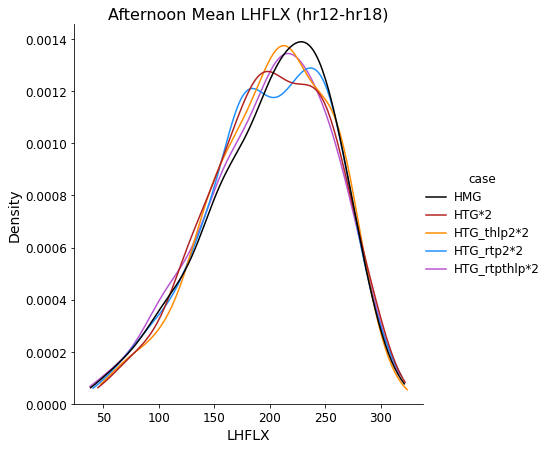

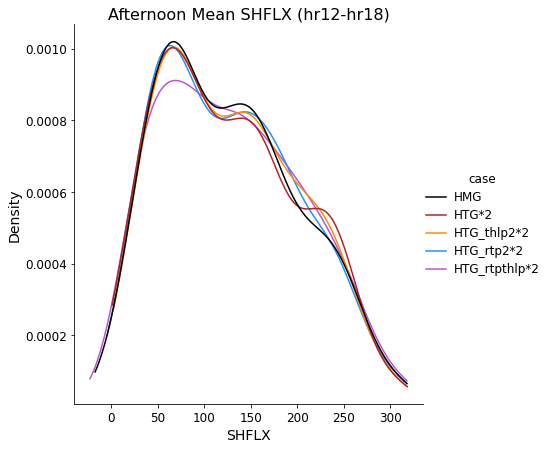

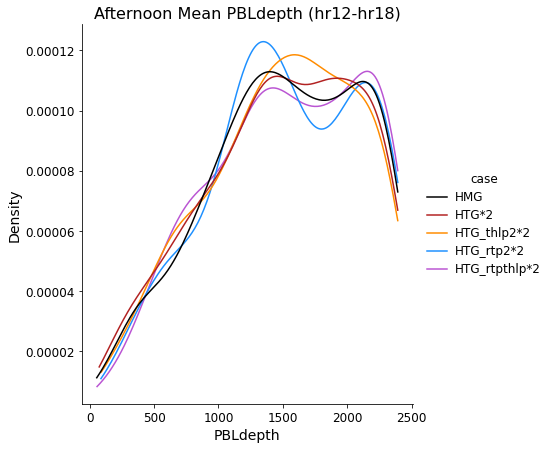

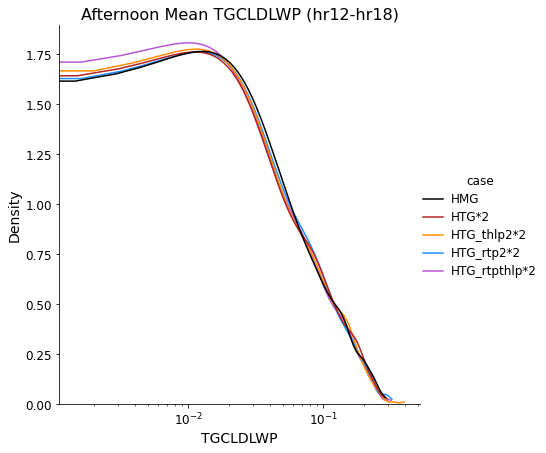

In [24]:
pltDistVar = plotPDFS_distVar_mult2('LHFLX',0)
pltDistVar = plotPDFS_distVar_mult2('SHFLX',0)

pltDistVar = plotPDFS_distVar_mult2('PBLdepth',0)
pltDistVar = plotPDFS_distVar_mult2('TGCLDLWP',1)



### Pick out days where changes are large

In [17]:
## Now get the dates where the HTG case has a really different behavior than the HMG one... 
diff_realHTG   = np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG')[0])) - np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]))


highPct = 90
lowPct  = 10

print('Real Surface:')
print('- - - - - - - - ')
print(highPct, 'th percentile difference (HTG): %.3e'  % np.nanpercentile(diff_realHTG, highPct))
print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(diff_realHTG, lowPct))
print()
iHigh_realHTG  = np.where(diff_realHTG   >= np.nanpercentile(diff_realHTG, highPct))[0]
iLow_realHTG   = np.where(diff_realHTG   <= np.nanpercentile(diff_realHTG, lowPct))[0]


## Get indices of dates that are consistent...
listHigh_real = list(set( iHigh_realHTG )  )
listLow_real  = list(set( iLow_realHTG ) )

print('Num days consistent for high percentile (real sfc): ', len(listHigh_real))
print('Num days consistent for low  percentile (real sfc): ', len(listLow_real))


Real Surface:
- - - - - - - - 
90 th percentile difference (HTG): 1.679e+02
10 th percentile difference (HTG):  -1.841e+02

Num days consistent for high percentile (real sfc):  35
Num days consistent for low  percentile (real sfc):  35


In [16]:
print('Realistic Surface')
print('Days with large LWP increases: \n')
for iDay in range(len(listHigh_real)):
    print('    ', strDates[np.sort(listHigh_real)][iDay])
print('\nDays with large LWP decreases: \n')
for iDay in range(len(listLow_real)):
    print('    ', strDates[np.sort(listLow_real)][iDay])

Realistic Surface
Days with large LWP increases: 

     2015-06-10
     2015-06-11
     2015-06-12
     2015-06-30
     2015-07-05
     2015-07-10
     2015-07-11
     2015-07-13
     2015-07-17
     2015-07-18
     2015-08-09
     2015-08-10
     2016-06-07
     2016-07-04
     2016-07-06
     2016-07-22
     2016-07-25
     2016-08-07
     2016-08-12
     2016-08-26
     2016-08-27
     2017-06-09
     2017-06-22
     2017-06-29
     2017-07-04
     2017-07-13
     2017-07-14
     2017-07-28
     2017-08-04
     2017-08-07
     2017-08-08
     2017-08-20
     2018-08-07
     2018-08-11
     2018-08-27

Days with large LWP decreases: 

     2015-06-14
     2015-06-25
     2015-06-28
     2015-07-14
     2015-07-22
     2015-07-24
     2015-07-25
     2015-07-26
     2015-07-27
     2015-07-29
     2015-08-25
     2016-06-08
     2016-06-24
     2016-06-28
     2016-07-07
     2016-07-08
     2016-07-21
     2016-07-23
     2016-07-26
     2016-07-31
     2016-08-01
     2016-08-05
   

In [18]:
# Get indices for all the other days too
allIndicies        = np.arange(0,len(strDates))
restOfIndices_real = list(set(allIndicies) - set(listHigh_real) - set(listLow_real))


In [ ]:
## Colors:
#   'black','firebrick','darkorange','dodgerblue','mediumorchid'

## Labels: 
#    HMG, HTG, HTG_thlp2, HTG_rtp2, HTG_rtpthlp

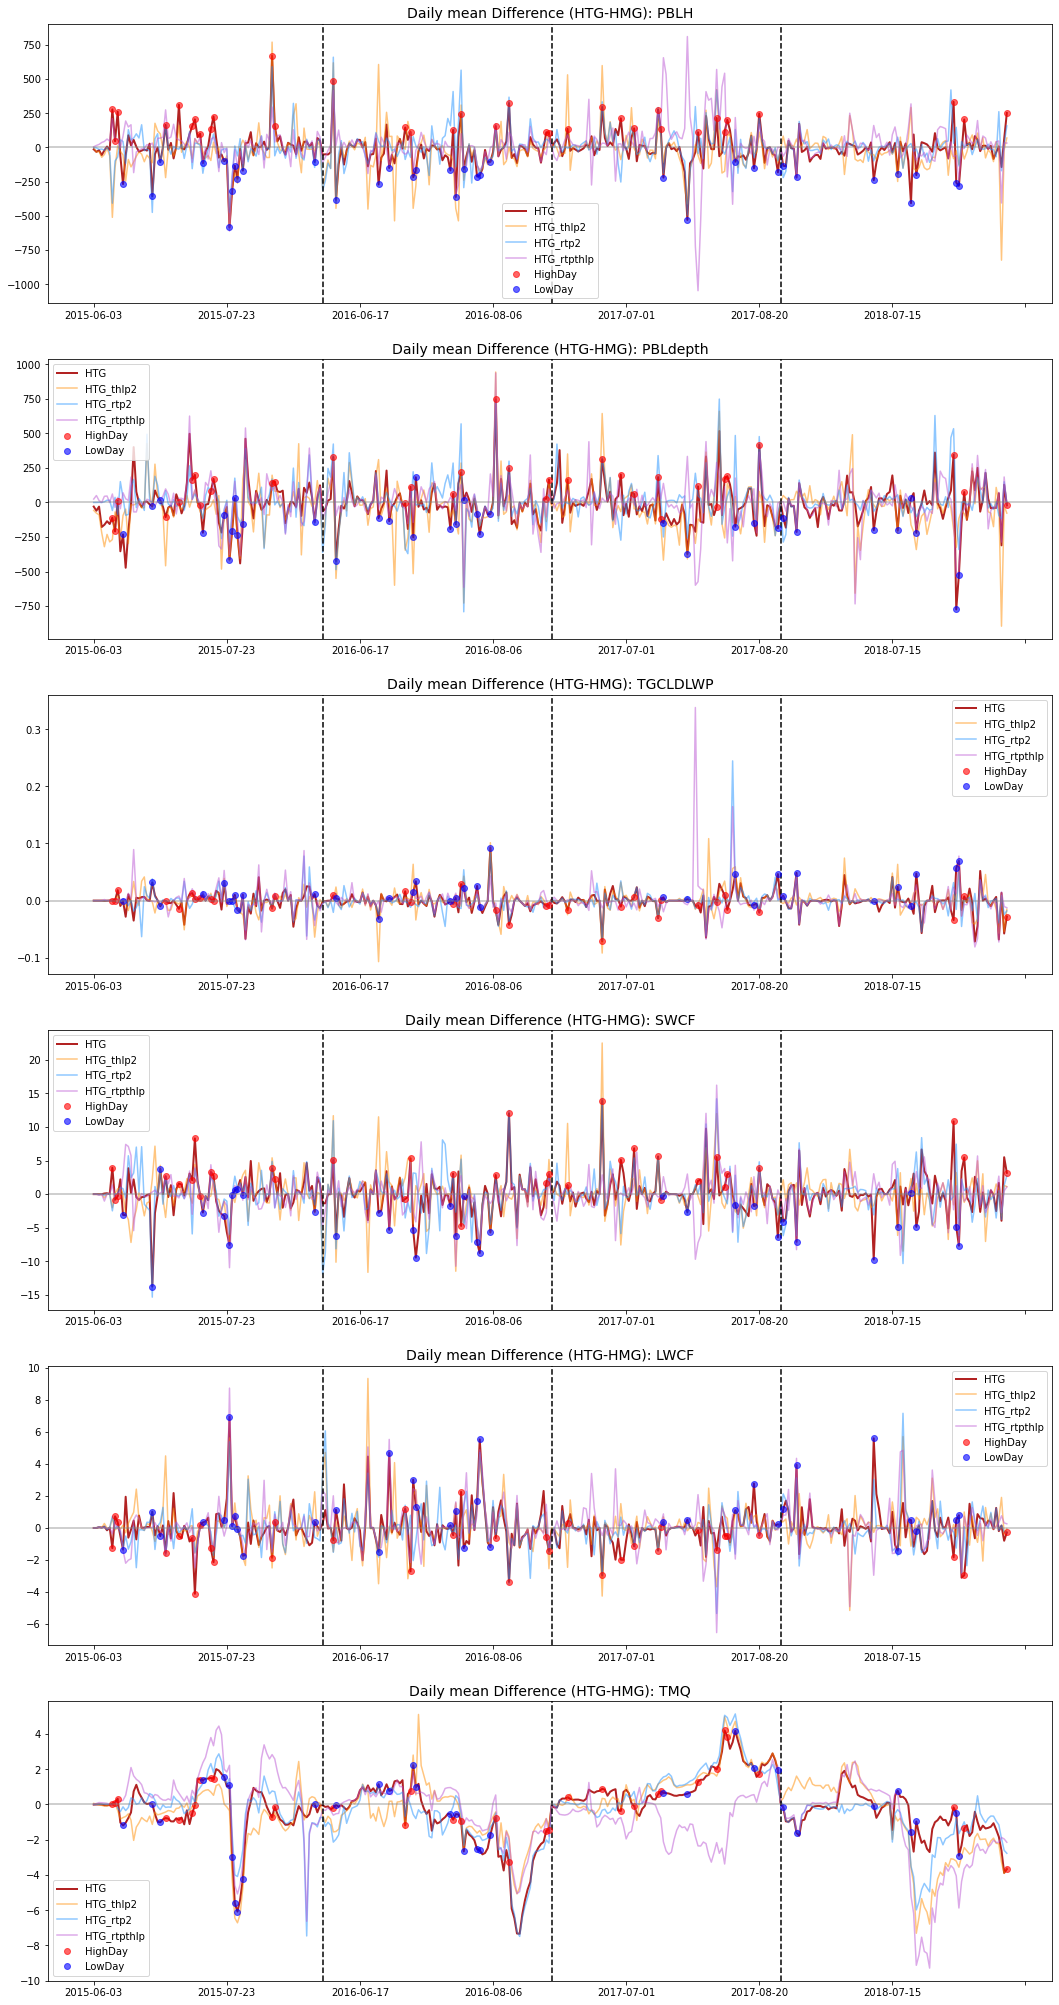

In [29]:
# Plot daily means...
plotVars = np.asarray(['PBLH','PBLdepth','TGCLDLWP','SWCF','LWCF','TMQ'])
nPlots = len(plotVars)

fig,axs = plt.subplots(nPlots,1, figsize=(18,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_var         = realSfc_allCases[plotVars[iPlot]]
    iHours_real      = np.where( (real_var['time.hour']>=8) & (real_var['time.hour']<=20) )[0]
    real_var_selTime = real_var.isel(time=iHours_real)

    # For each date, get the mean value over the day
#     real_var_dayMean = real_var.groupby('year_month_day').mean(dim='time')
    real_var_dayMean = real_var_selTime.groupby('year_month_day').mean(dim='time')

    
    diffHTG   = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values
    diffHTGthlp    = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_thlp2')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values
    diffHTGrtp     = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtp2')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values
    diffHTGrtpthlp = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtpthlp')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values

    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG))), np.squeeze(diffHTG), 
                    color='firebrick',linewidth=2, label='HTG')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTGthlp))), np.squeeze(diffHTGthlp), 
                    color='darkorange', alpha=0.5, label='HTG_thlp2')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTGrtp))), np.squeeze(diffHTGrtp), 
                    color='dodgerblue', alpha=0.5, label='HTG_rtp2')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTGrtpthlp))), np.squeeze(diffHTGrtpthlp), 
                    color='mediumorchid', alpha=0.5, label='HTG_rtpthlp')

    ## Add separating lines for ease of looking at these 
#     axs.axhline(0,color='k',linestyle='--')
    for iYr in range(len(yrStart)):
        axs[iPlot].axvline(yrStart[iYr], color='k',linestyle='--')


    # Plot markers for days that qualify as high/low changes
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG)))[listHigh_real], np.squeeze(diffHTG)[listHigh_real],'ro', alpha=0.6, label='HighDay')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG)))[listLow_real],  np.squeeze(diffHTG)[listLow_real],'bo',  alpha=0.6, label='LowDay')

    axs[iPlot].legend()
    axs[iPlot].axhline(0,color='grey',alpha=0.5)
    
    # Add labels
    axs[iPlot].set_title('Daily mean Difference (HTG-HMG): '+plotVars[iPlot],fontsize=14)

    # Control tick labels
    xTicks       = axs[iPlot].get_xticks()
    dates_xticks = strDates[xTicks.astype(int)[:-2]]
    axs[iPlot].set_xticklabels(dates_xticks)
    

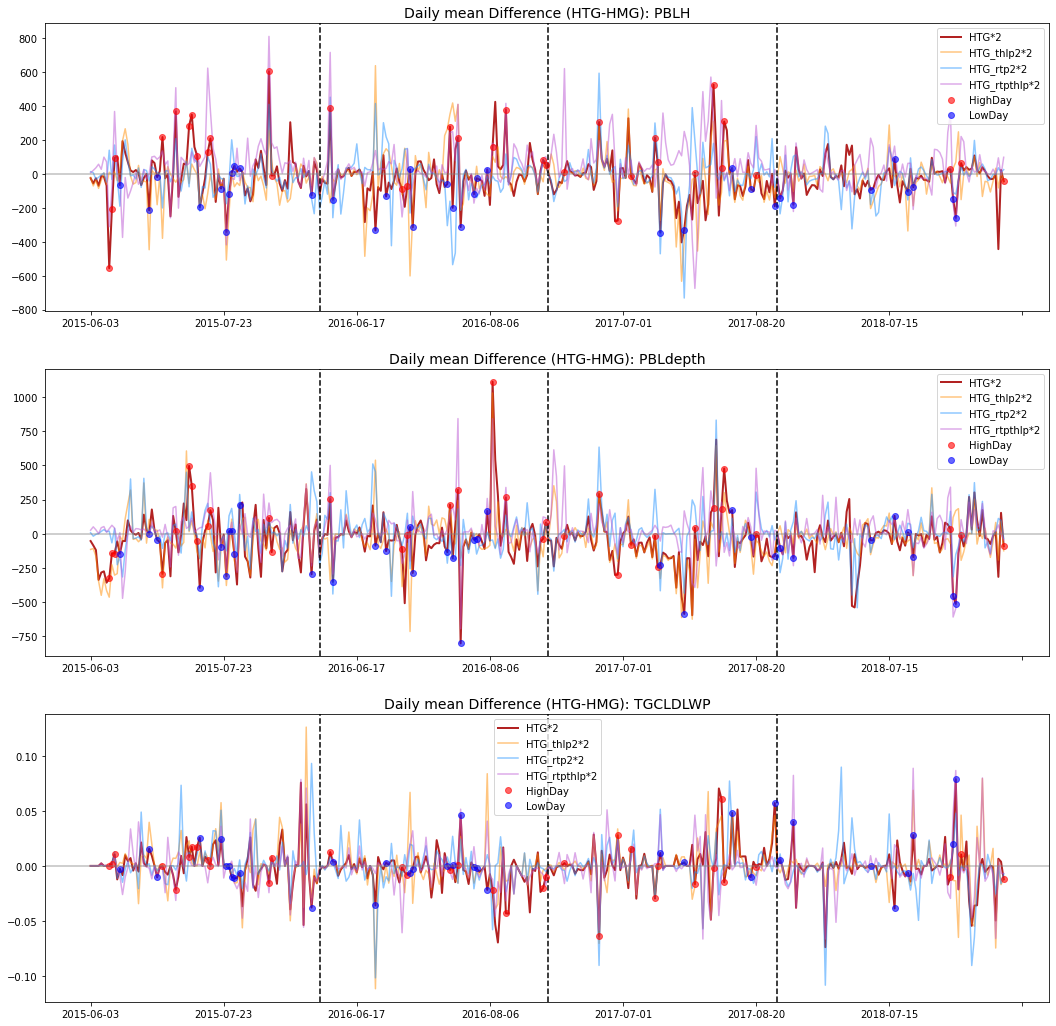

In [19]:
# Plot daily means...
plotVars = np.asarray(['PBLH','PBLdepth','TGCLDLWP'])
nPlots = len(plotVars)

fig,axs = plt.subplots(nPlots,1, figsize=(18,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_var         = realSfc_allCases[plotVars[iPlot]]
    iHours_real      = np.where( (real_var['time.hour']>=8) & (real_var['time.hour']<=20) )[0]
    real_var_selTime = real_var.isel(time=iHours_real)

    # For each date, get the mean value over the day
#     real_var_dayMean = real_var.groupby('year_month_day').mean(dim='time')
    real_var_dayMean = real_var_selTime.groupby('year_month_day').mean(dim='time')

    
    diffHTG   = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG*2')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values
    diffHTGthlp    = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_thlp2*2')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values
    diffHTGrtp     = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtp2*2')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values
    diffHTGrtpthlp = real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG_rtpthlp*2')[0]).values-real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]).values

    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG))), np.squeeze(diffHTG), 
                    color='firebrick',linewidth=2, label='HTG*2')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTGthlp))), np.squeeze(diffHTGthlp), 
                    color='darkorange', alpha=0.5, label='HTG_thlp2*2')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTGrtp))), np.squeeze(diffHTGrtp), 
                    color='dodgerblue', alpha=0.5, label='HTG_rtp2*2')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTGrtpthlp))), np.squeeze(diffHTGrtpthlp), 
                    color='mediumorchid', alpha=0.5, label='HTG_rtpthlp*2')

    ## Add separating lines for ease of looking at these 
#     axs.axhline(0,color='k',linestyle='--')
    for iYr in range(len(yrStart)):
        axs[iPlot].axvline(yrStart[iYr], color='k',linestyle='--')


    # Plot markers for days that qualify as high/low changes
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG)))[listHigh_real], np.squeeze(diffHTG)[listHigh_real],'ro', alpha=0.6, label='HighDay')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG)))[listLow_real],  np.squeeze(diffHTG)[listLow_real],'bo',  alpha=0.6, label='LowDay')

    axs[iPlot].legend()
    axs[iPlot].axhline(0,color='grey',alpha=0.5)
    
    # Add labels
    axs[iPlot].set_title('Daily mean Difference (HTG-HMG): '+plotVars[iPlot],fontsize=14)

    # Control tick labels
    xTicks       = axs[iPlot].get_xticks()
    dates_xticks = strDates[xTicks.astype(int)[:-2]]
    axs[iPlot].set_xticklabels(dates_xticks)
    

In [20]:
## Get full arrays that match low/high percentiles that are consistent across surface definition 
#    ( so one set for real surface cases and one for the artificial surface cases )

# Real surface 
highPct_realSfc  = getTimes_basedOnDates(realSfc_allCases,     
                                         real_var_dayMean.isel(year_month_day=listHigh_real))
lowPct_realSfc   = getTimes_basedOnDates(realSfc_allCases,     
                                         real_var_dayMean.isel(year_month_day=listLow_real))
print('Done with real surface cases ')



Done with real surface cases 


In [21]:
## Get arrays with other % of days that don't fall into the category of the extremes 
restOfDays_realSfc          = getTimes_basedOnDates(realSfc_allCases,     
                                                    real_var_dayMean.isel(year_month_day=restOfIndices_real))
print('Done getting datasets with rest of the days')


Done getting datasets with rest of the days


In [22]:
## Get hourly means in each category 
## - - - - - - - - - - - - - - - - - - 

hourlyMean_highPct_realSfc         = highPct_realSfc.groupby("time.hour").mean(dim="time")
hourlyMean_lowPct_realSfc          = lowPct_realSfc.groupby("time.hour").mean(dim="time")
print('Computed hourly means for all surfaces + cases')

hourlyStd_highPct_realSfc   = highPct_realSfc.groupby("time.hour").std(dim="time")
hourlyStd_lowPct_realSfc    = lowPct_realSfc.groupby("time.hour").std(dim="time")
print('Computed hourly std for all surfaces + cases')


## Get large scale/obs information too
hourlyMean_restOfDays_realSfc     = restOfDays_realSfc.groupby("time.hour").mean(dim="time")
print('Computed means for rest of days')

hourlyStd_restOfDays_realSfc     = restOfDays_realSfc.groupby("time.hour").std(dim="time")
print('Computed std for rest of days')



Computed hourly means for all surfaces + cases
Computed hourly std for all surfaces + cases
Computed means for rest of days
Computed std for rest of days


In [23]:
# Get number of obs going into those hourly means (for error bars)
nTimes_highPct_realSfc     = np.full([24], np.nan)
nTimes_lowPct_realSfc      = np.full([24], np.nan)
nTimes_restOfDays_realSfc  = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_highPct_realSfc[iHr]    = len(np.where(highPct_realSfc["time.hour"]==iHr)[0])
    nTimes_lowPct_realSfc[iHr]     = len(np.where(lowPct_realSfc["time.hour"]==iHr)[0])
    nTimes_restOfDays_realSfc[iHr] = len(np.where(restOfDays_realSfc["time.hour"]==iHr)[0])
    
hourlyMean_highPct_realSfc['SampleCount']       = (('hour'), nTimes_highPct_realSfc)
hourlyMean_lowPct_realSfc['SampleCount']        = (('hour'), nTimes_lowPct_realSfc)
hourlyMean_restOfDays_realSfc['SampleCount']    = (('hour'), nTimes_restOfDays_realSfc)


In [24]:
def plotDiurnalCycle_sensDays(varSelPlot, levSel, yMax, yMin):
    
    fig,axs = plt.subplots(1,3, figsize=(15,5))
    axs     = axs.ravel()

    colorsList = np.asarray(['black','firebrick','darkorange','dodgerblue','mediumorchid'])
    
    iCase_HMG = np.where(hourlyMean_highPct_realSfc.case.values=='HMG')[0]
    iCase_HTG = np.where(hourlyMean_highPct_realSfc.case.values=='HTG')[0]
    iCase_HTGthlp2   = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_thlp2')[0]
    iCase_HTGrtp2    = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtp2')[0]
    iCase_HTGrtpthlp = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtpthlp')[0]

    
    #  High Pct days
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[0],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[1],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[2],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[3],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[4],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp][0])
    axs[0].legend(fontsize=12)


    #  Low Pct days
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[0],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HMG])
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[1],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTG])
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[2],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTGthlp2])    
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[3],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTGrtp2])
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[4],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTGrtpthlp])
     
    
    #  Rest of days 
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[0],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HMG])
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[1],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTG])
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[2],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTGthlp2])
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[3],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTGrtp2])    
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[4],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTGrtpthlp])
    
    # Set labels
    # axs[0].set_title(varSelPlot+'\n High percentiles of '+varSel+' (realSfc)', fontsize=14)
    axs[0].set_title(varSelPlot+'\n Large increases in '+varSel, fontsize=16)
    axs[1].set_title('Large decreases in '+varSel, fontsize=16)
    axs[2].set_title('Remaining days ', fontsize=16)
 
    if hasattr(realSfc_allCases[varSelPlot], 'units'):
        axs[0].set_ylabel(realSfc_allCases[varSelPlot].units, fontsize=12)
        
    axs[0].set_xlabel('Local Hour', fontsize=12)
    axs[1].set_xlabel('Local Hour', fontsize=12)
    axs[2].set_xlabel('Local Hour', fontsize=12)

    axs[0].tick_params(axis='both', labelsize= 12)
    axs[1].tick_params(axis='both', labelsize= 12)
    axs[2].tick_params(axis='both', labelsize= 12)

    # Set axis ranges if desired
    axs[0].set_ylim([yMin, yMax])
    axs[1].set_ylim([yMin, yMax])
    axs[2].set_ylim([yMin, yMax])
    
    return axs 

In [25]:
def plotDiurnalCycle_sensDays_multipliers(varSelPlot, levSel, yMax, yMin):
    
    fig,axs = plt.subplots(3,4, figsize=(20,15))
    axs     = axs.ravel()
    
    iCase_HMG  = np.where(hourlyMean_highPct_realSfc.case.values=='HMG')[0]
    iCase_HTG  = np.where(hourlyMean_highPct_realSfc.case.values=='HTG')[0]
    iCase_HTG2 = np.where(hourlyMean_highPct_realSfc.case.values=='HTG*2')[0]
        
    iCase_HTGthlp2   = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_thlp2')[0]
    iCase_HTGrtp2    = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtp2')[0]
    iCase_HTGrtpthlp = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtpthlp')[0]
    
    iCase_HTGthlp2_mult2   = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_thlp2*2')[0]
    iCase_HTGrtp2_mult2    = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtp2*2')[0]
    iCase_HTGrtpthlp_mult2 = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtpthlp*2')[0]

    
    #  High Pct days
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='firebrick',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTG2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTG2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='red',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG2][0])

    
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='darkorange',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2][0])
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2_mult2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='gold',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2_mult2][0])
    
    
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='dodgerblue',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2][0])
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2_mult2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='teal',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2_mult2][0])
    
    axs[3].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[3].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='mediumorchid',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp][0])
    axs[3].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp_mult2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color='hotpink',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp_mult2][0])
    
    axs[0].legend(fontsize=12)
    axs[1].legend(fontsize=12)
    axs[2].legend(fontsize=12)
    axs[3].legend(fontsize=12)
    
    # --------------------------------------------------------------------------------
    
    #  Low Pct days
    axs[4].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])
    axs[4].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='firebrick',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG][0])
    axs[4].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTG2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTG2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='red',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG2][0])

    
    axs[5].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[5].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='darkorange',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2][0])
    axs[5].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2_mult2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='gold',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2_mult2][0])
    
    
    axs[6].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[6].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='dodgerblue',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2][0])
    axs[6].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2_mult2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='teal',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2_mult2][0])
    
    axs[7].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[7].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='mediumorchid',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp][0])
    axs[7].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp_mult2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color='hotpink',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp_mult2][0])
   
    # --------------------------------------------------------------------------------
         
    #  Rest of days 
    
    axs[8].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])
    axs[8].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='firebrick',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG][0])
    axs[8].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='red',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG2][0])

    
    axs[9].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[9].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='darkorange',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2][0])
    axs[9].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2_mult2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='gold',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2_mult2][0])
    
    
    axs[10].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[10].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='dodgerblue',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2][0])
    axs[10].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2_mult2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='teal',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2_mult2][0])
    
    axs[11].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='black',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])     
    axs[11].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='mediumorchid',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp][0])
    axs[11].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp_mult2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp_mult2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    fmt='-',color='hotpink',capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp_mult2][0])    
    
    
    
    
        
    # Set labels
    # axs[0].set_title(varSelPlot+'\n High percentiles of '+varSel+' (realSfc)', fontsize=14)
    axs[0].set_title(varSelPlot+'\n Large increases in '+varSel, fontsize=16)
    axs[4].set_title('Large decreases in '+varSel, fontsize=16)
    axs[8].set_title('Remaining days ', fontsize=16)
 
    if hasattr(realSfc_allCases[varSelPlot], 'units'):
        axs[0].set_ylabel(realSfc_allCases[varSelPlot].units, fontsize=12)
        axs[4].set_ylabel(realSfc_allCases[varSelPlot].units, fontsize=12)
        axs[8].set_ylabel(realSfc_allCases[varSelPlot].units, fontsize=12)
        
    axs[8].set_xlabel('Local Hour', fontsize=12)
    axs[9].set_xlabel('Local Hour', fontsize=12)
    axs[10].set_xlabel('Local Hour', fontsize=12)
    axs[11].set_xlabel('Local Hour', fontsize=12)

    axs[0].tick_params(axis='both', labelsize= 12)
    axs[1].tick_params(axis='both', labelsize= 12)
    axs[2].tick_params(axis='both', labelsize= 12)
    axs[3].tick_params(axis='both', labelsize= 12)
    axs[4].tick_params(axis='both', labelsize= 12)
    axs[5].tick_params(axis='both', labelsize= 12)
    axs[6].tick_params(axis='both', labelsize= 12)
    axs[7].tick_params(axis='both', labelsize= 12)
    axs[8].tick_params(axis='both', labelsize= 12)
    axs[9].tick_params(axis='both', labelsize= 12)
    axs[10].tick_params(axis='both', labelsize= 12)
    axs[11].tick_params(axis='both', labelsize= 12)
    
    # Set axis ranges if desired
    axs[0].set_ylim([yMin, yMax])
    axs[1].set_ylim([yMin, yMax])
    axs[2].set_ylim([yMin, yMax])
    axs[3].set_ylim([yMin, yMax])
    axs[4].set_ylim([yMin, yMax])
    axs[5].set_ylim([yMin, yMax])
    axs[6].set_ylim([yMin, yMax])
    axs[7].set_ylim([yMin, yMax])
    axs[8].set_ylim([yMin, yMax])
    axs[9].set_ylim([yMin, yMax])
    axs[10].set_ylim([yMin, yMax])
    axs[11].set_ylim([yMin, yMax])
            
    return axs 

In [26]:
def plotDiurnalCycle_sensDays_multipliersOnePanel(varSelPlot, levSel, yMax, yMin):
    
    fig,axs = plt.subplots(1,3, figsize=(15,5))
    axs     = axs.ravel()

    colorsList = np.asarray(['black','firebrick','darkorange','dodgerblue','mediumorchid'])
    
    iCase_HMG = np.where(hourlyMean_highPct_realSfc.case.values=='HMG')[0]
    iCase_HTG = np.where(hourlyMean_highPct_realSfc.case.values=='HTG*2')[0]
    iCase_HTGthlp2   = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_thlp2*2')[0]
    iCase_HTGrtp2    = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtp2*2')[0]
    iCase_HTGrtpthlp = np.where(hourlyMean_highPct_realSfc.case.values=='HTG_rtpthlp*2')[0]

    
    #  High Pct days
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[0],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HMG][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[1],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTG][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[2],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGthlp2][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[3],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtp2][0])
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_highPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_highPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[4],capsize=3,label=hourlyMean_highPct_realSfc.case.values[iCase_HTGrtpthlp][0])
    axs[0].legend(fontsize=12)


    #  Low Pct days
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[0],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HMG])
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[1],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTG])
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[2],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTGthlp2])    
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[3],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTGrtp2])
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_lowPct_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_lowPct_realSfc['SampleCount'].values),
                    fmt='-',color=colorsList[4],capsize=3,label=hourlyMean_lowPct_realSfc.case.values[iCase_HTGrtpthlp])
     
    
    #  Rest of days 
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HMG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[0],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HMG])
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTG,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[1],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTG])
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGthlp2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[2],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTGthlp2])
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtp2,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[3],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTGrtp2])    
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel]),
                    yerr =2*np.squeeze(hourlyStd_restOfDays_realSfc[varSelPlot].values[:,iCase_HTGrtpthlp,levSel])/np.sqrt(hourlyMean_restOfDays_realSfc['SampleCount'].values),
                    color=colorsList[4],capsize=3,label=hourlyMean_restOfDays_realSfc.case.values[iCase_HTGrtpthlp])
    
    # Set labels
    # axs[0].set_title(varSelPlot+'\n High percentiles of '+varSel+' (realSfc)', fontsize=14)
    axs[0].set_title(varSelPlot+'\n Large increases in '+varSel, fontsize=16)
    axs[1].set_title('Large decreases in '+varSel, fontsize=16)
    axs[2].set_title('Remaining days ', fontsize=16)
 
    if hasattr(realSfc_allCases[varSelPlot], 'units'):
        axs[0].set_ylabel(realSfc_allCases[varSelPlot].units, fontsize=12)
        
    axs[0].set_xlabel('Local Hour', fontsize=12)
    axs[1].set_xlabel('Local Hour', fontsize=12)
    axs[2].set_xlabel('Local Hour', fontsize=12)

    axs[0].tick_params(axis='both', labelsize= 12)
    axs[1].tick_params(axis='both', labelsize= 12)
    axs[2].tick_params(axis='both', labelsize= 12)

    # Set axis ranges if desired
    axs[0].set_ylim([yMin, yMax])
    axs[1].set_ylim([yMin, yMax])
    axs[2].set_ylim([yMin, yMax])
    
    return axs 

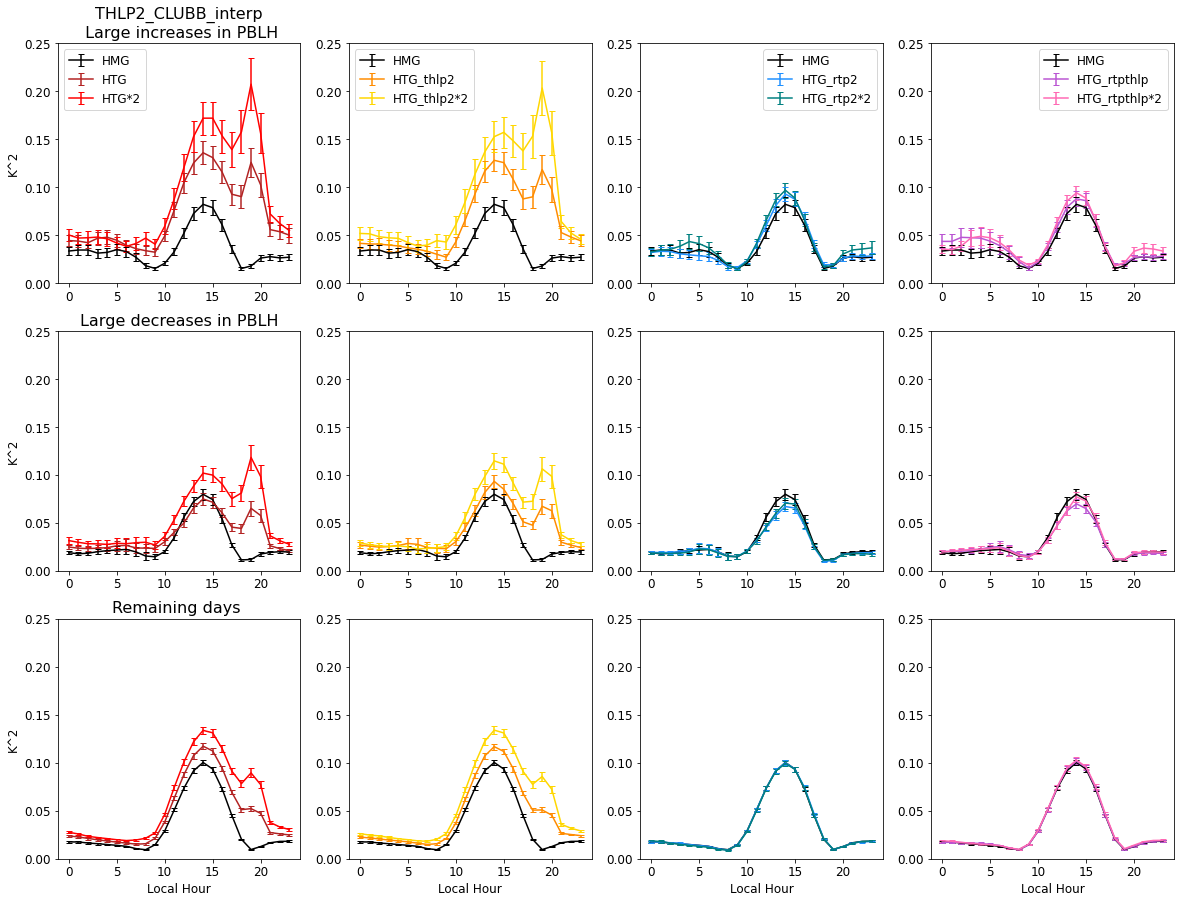

In [44]:
p1=plotDiurnalCycle_sensDays_multipliers('THLP2_CLUBB_interp',   -1, 0.25,   0.00)

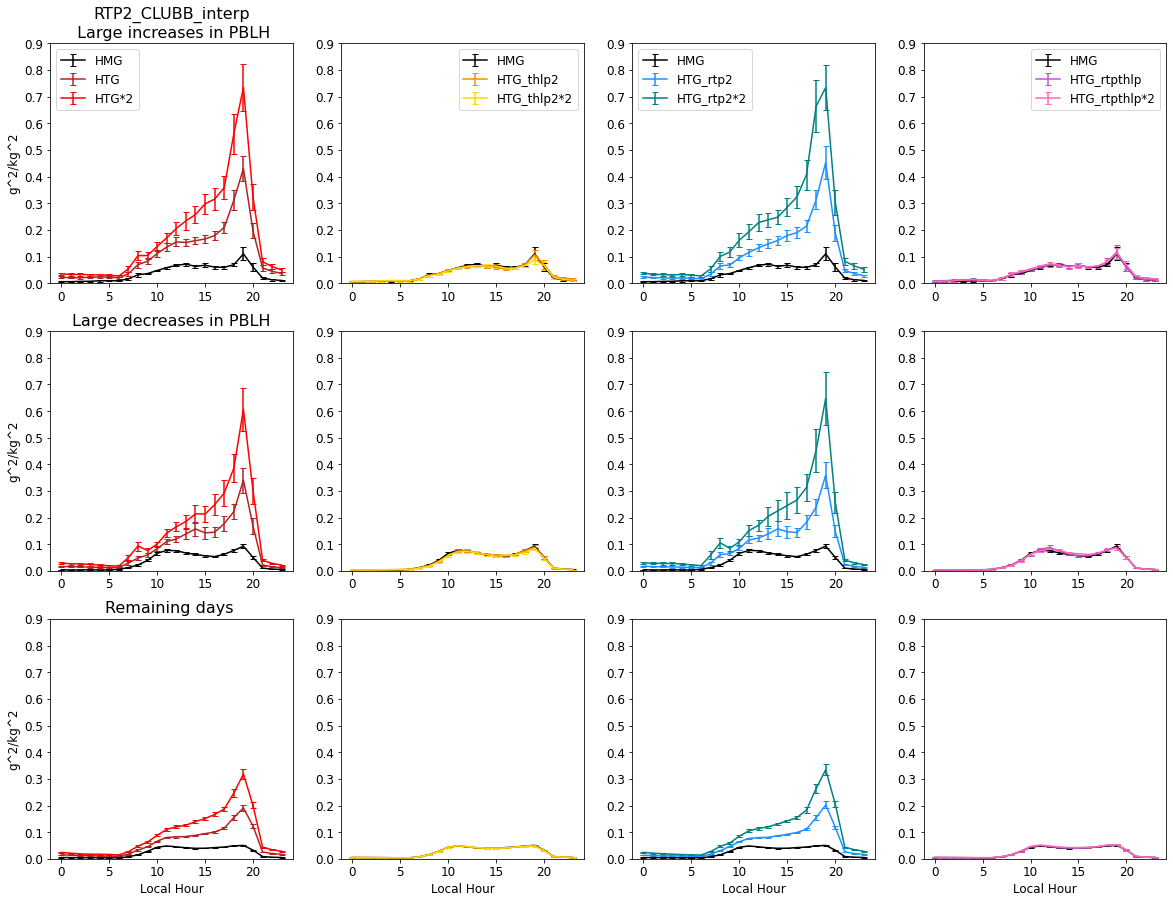

In [45]:
p2 = plotDiurnalCycle_sensDays_multipliers('RTP2_CLUBB_interp',    -1, 0.9,    0.00)

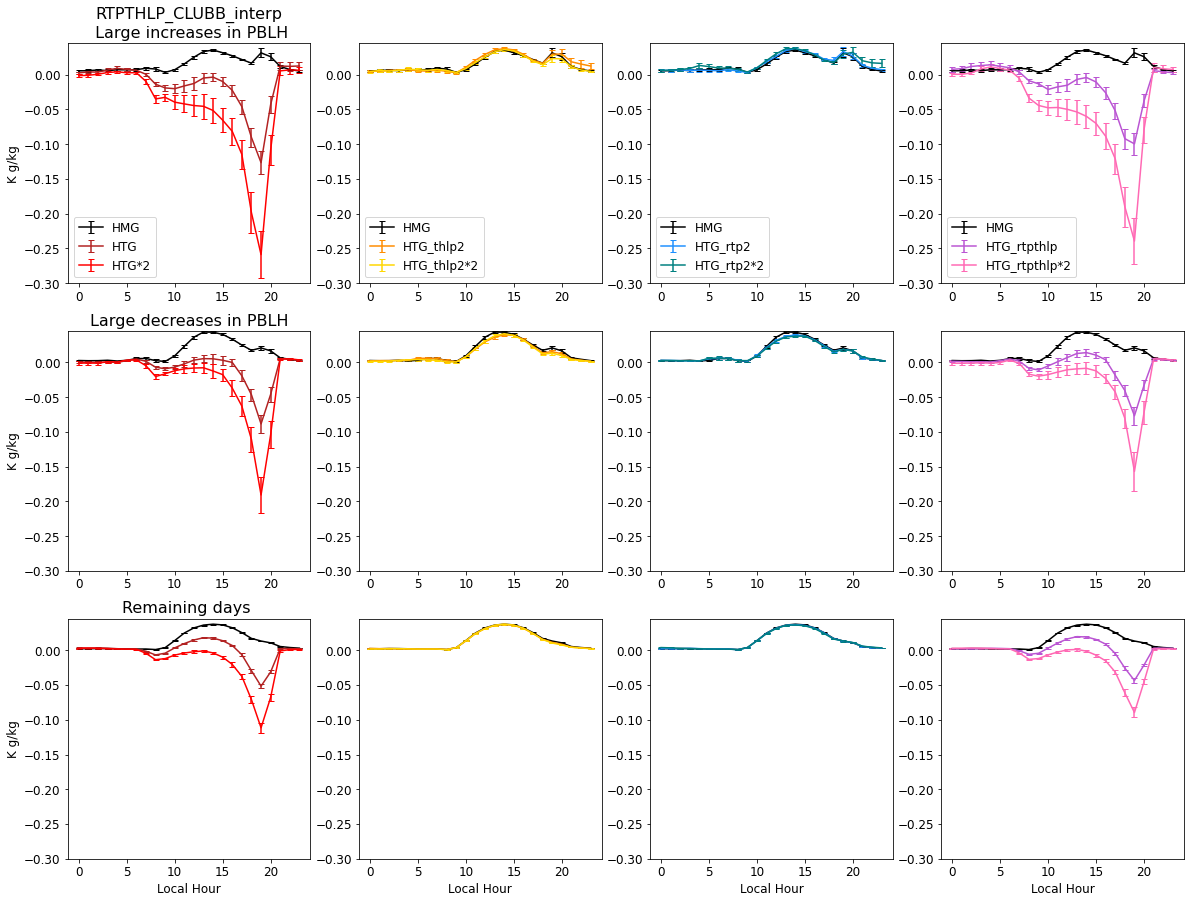

In [46]:
p3 = plotDiurnalCycle_sensDays_multipliers('RTPTHLP_CLUBB_interp', -1, 0.045, -0.3)

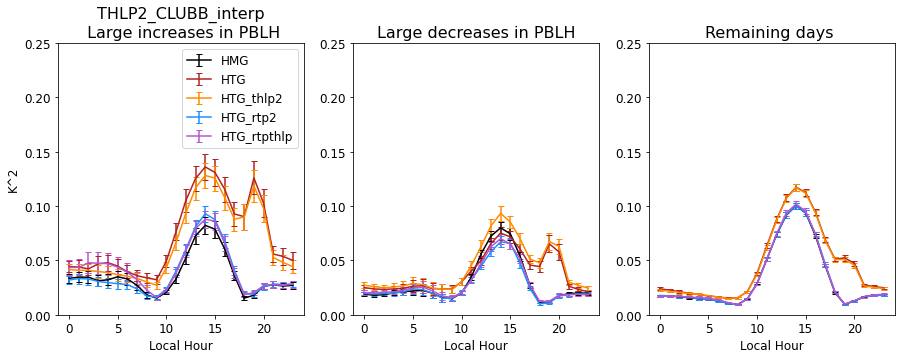

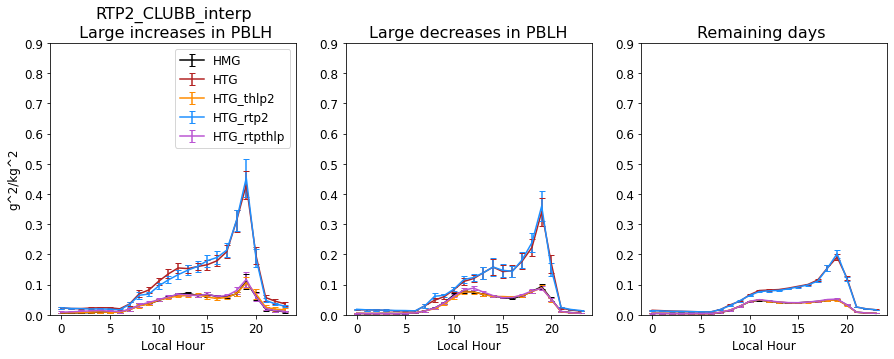

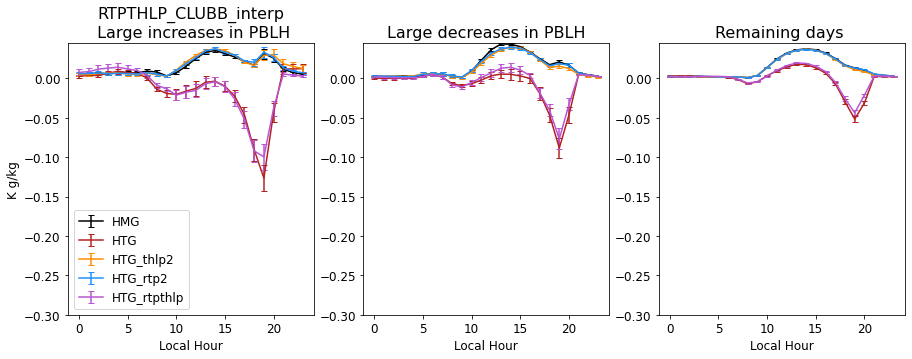

In [47]:
p1 = plotDiurnalCycle_sensDays('THLP2_CLUBB_interp',   -1, 0.25,   0.00)   #level, yMax, yMin are last three inputs
p2 = plotDiurnalCycle_sensDays('RTP2_CLUBB_interp',    -1, 0.9,    0.00)
p3 = plotDiurnalCycle_sensDays('RTPTHLP_CLUBB_interp', -1, 0.045, -0.3)



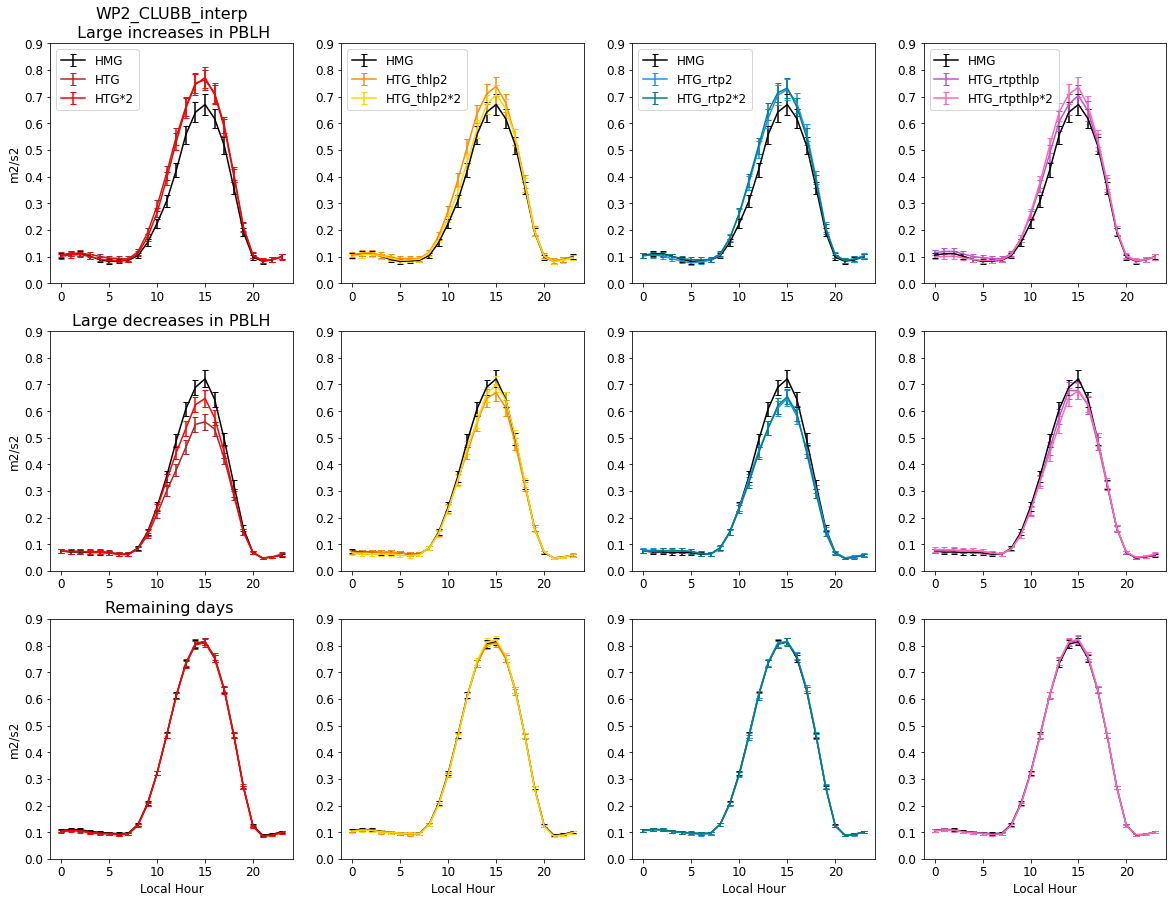

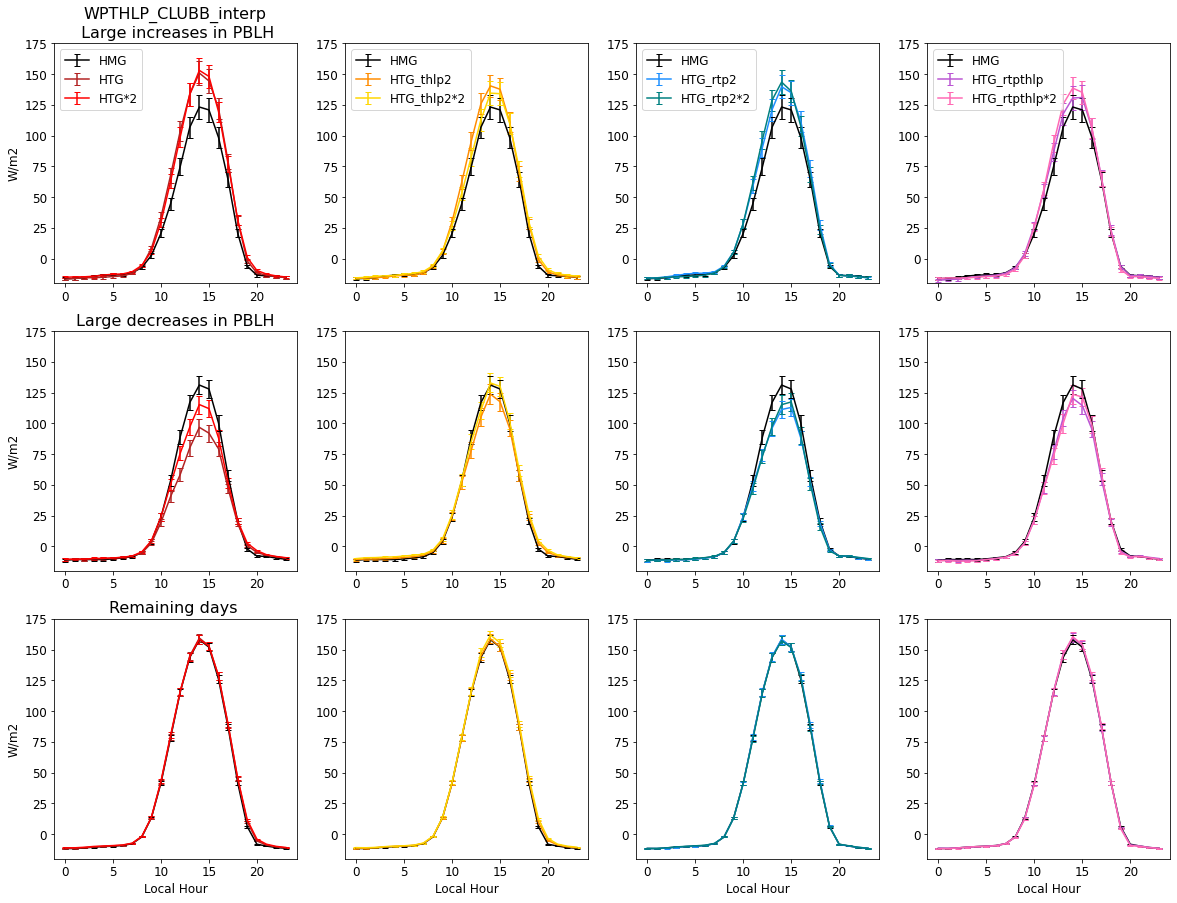

In [49]:
p1=plotDiurnalCycle_sensDays_multipliers('WP2_CLUBB_interp',    -1, 0.9, 0.0)   #level, yMax, yMin are last three inputs
p2=plotDiurnalCycle_sensDays_multipliers('WPTHLP_CLUBB_interp', -1, 175, -20)

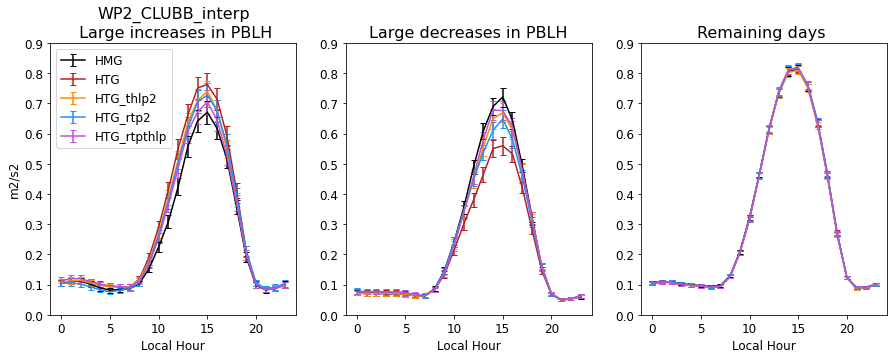

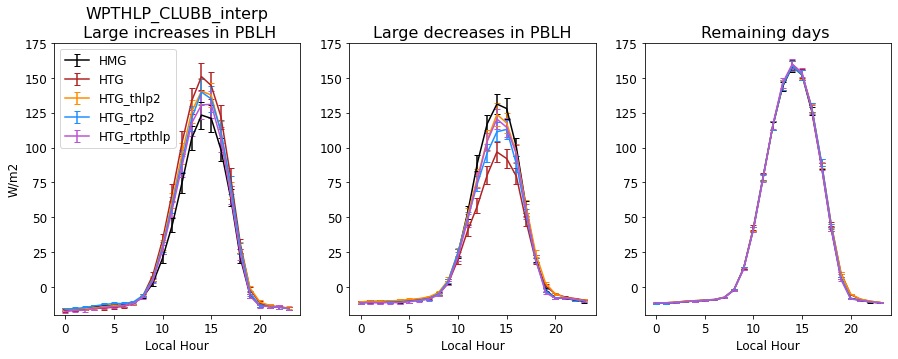

In [48]:
p1=plotDiurnalCycle_sensDays('WP2_CLUBB_interp',    -1, 0.9, 0.0)   #level, yMax, yMin are last three inputs
p2=plotDiurnalCycle_sensDays('WPTHLP_CLUBB_interp', -1, 175, -20)


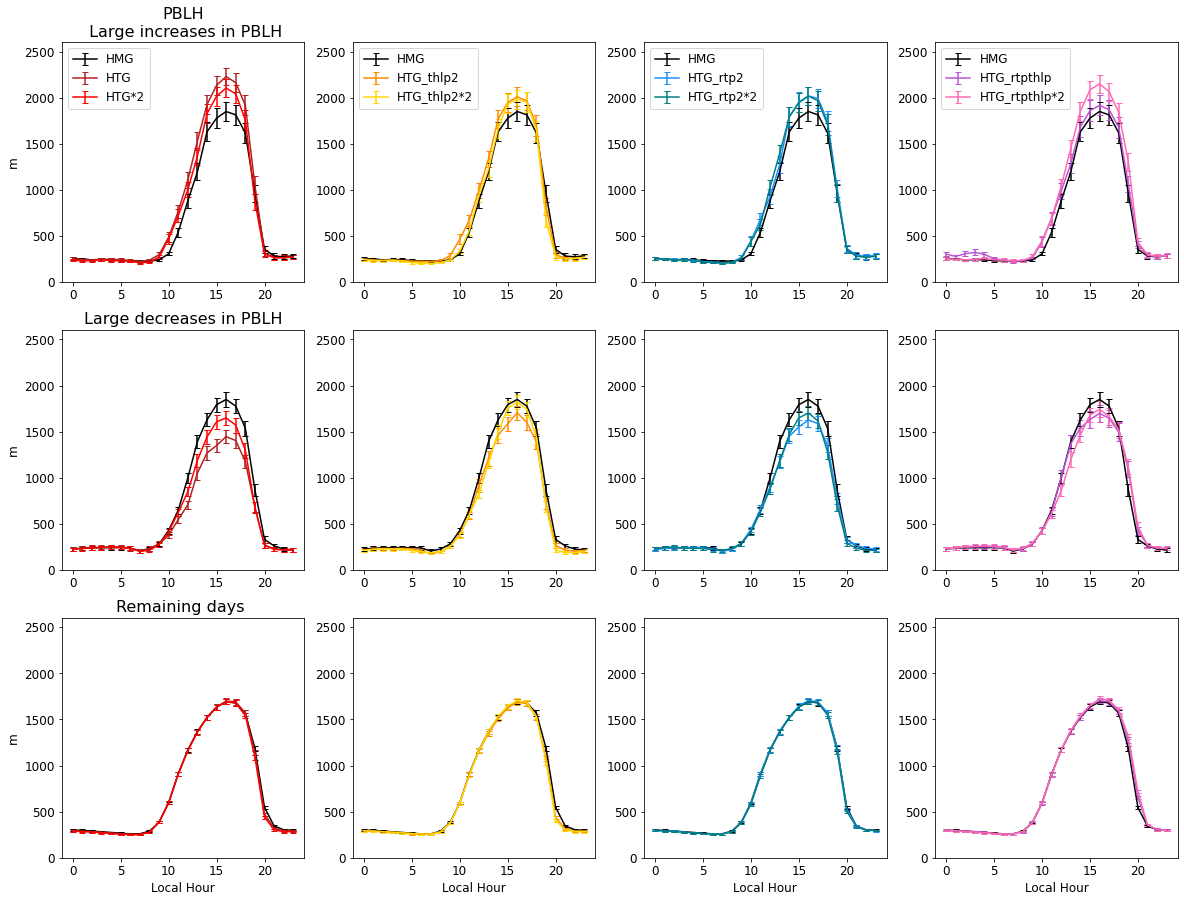

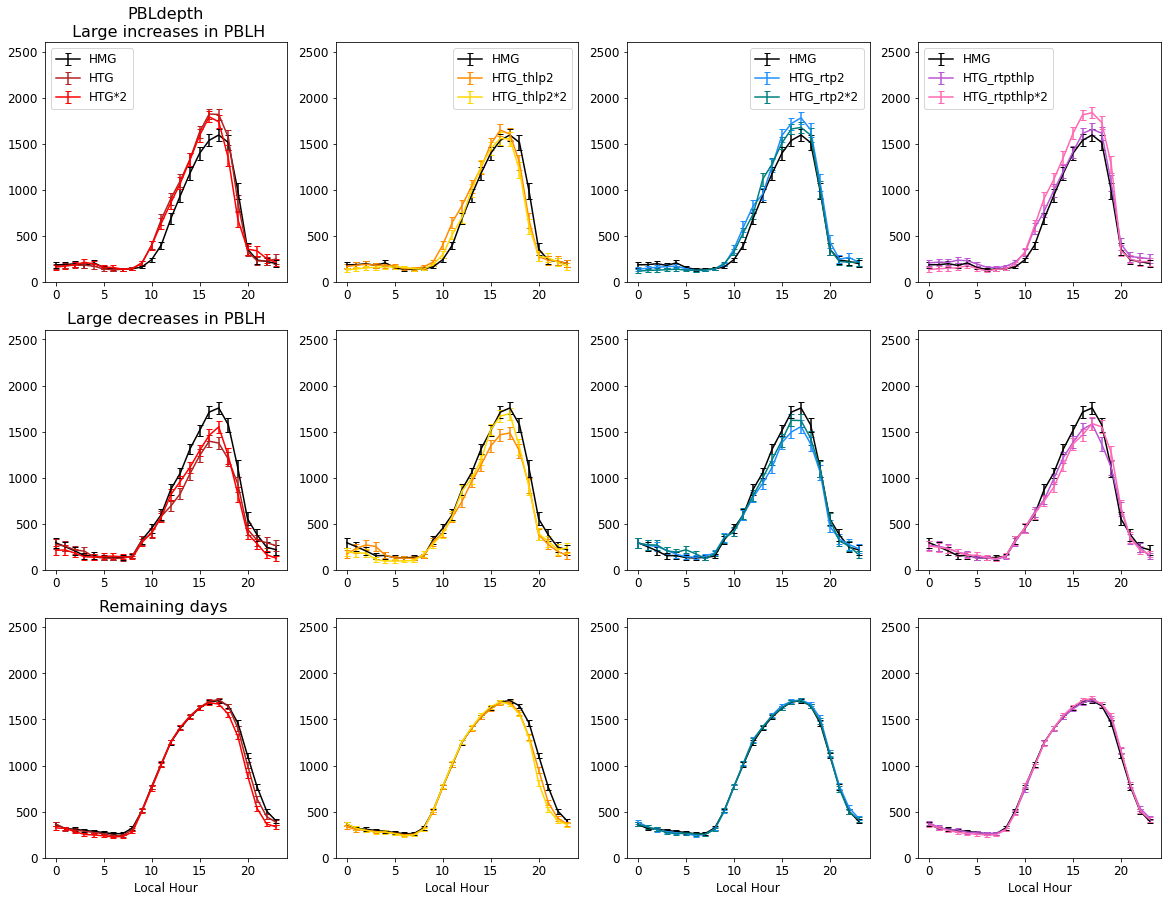

In [51]:
p1=plotDiurnalCycle_sensDays_multipliers('PBLH', None, 2600, 0)
p2=plotDiurnalCycle_sensDays_multipliers('PBLdepth', None, 2600, 0)


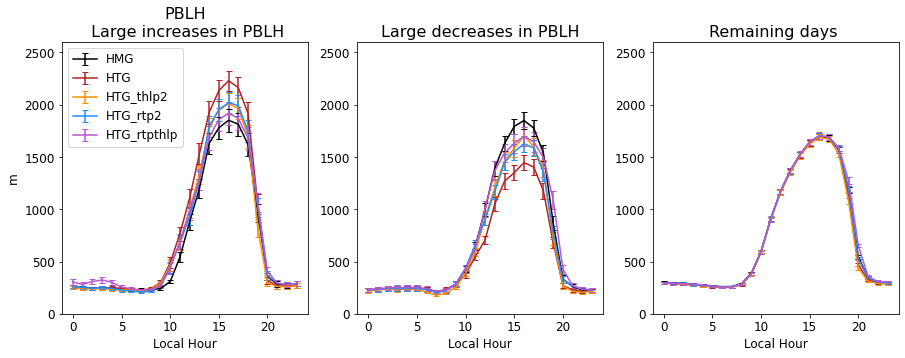

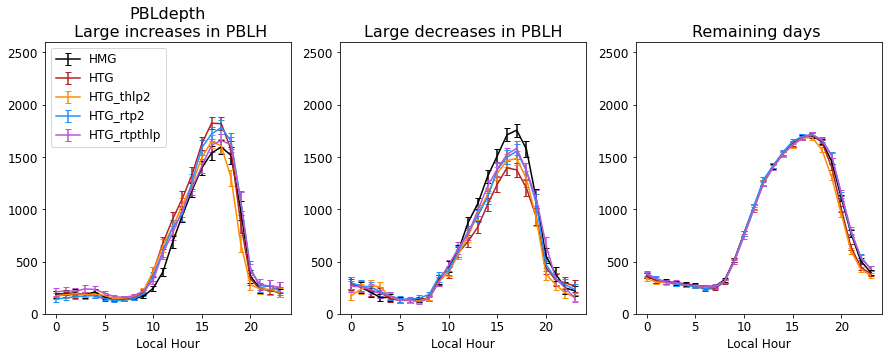

In [50]:
p1=plotDiurnalCycle_sensDays('PBLH', None, 2600, 0)
p2=plotDiurnalCycle_sensDays('PBLdepth', None, 2600, 0)


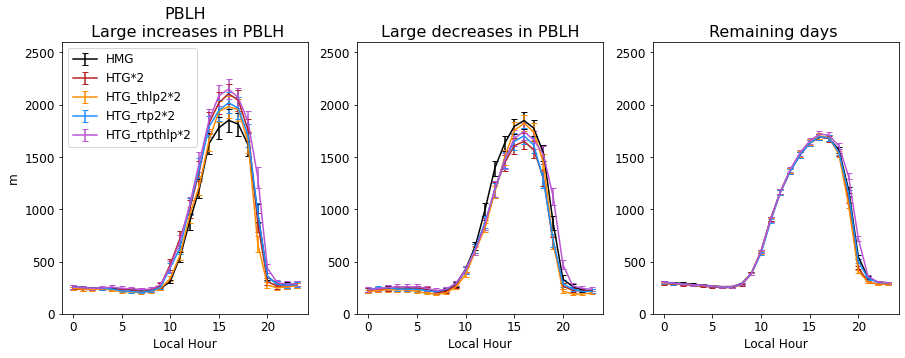

In [25]:
p1 = plotDiurnalCycle_sensDays_multipliersOnePanel('PBLH',None,2600,0)

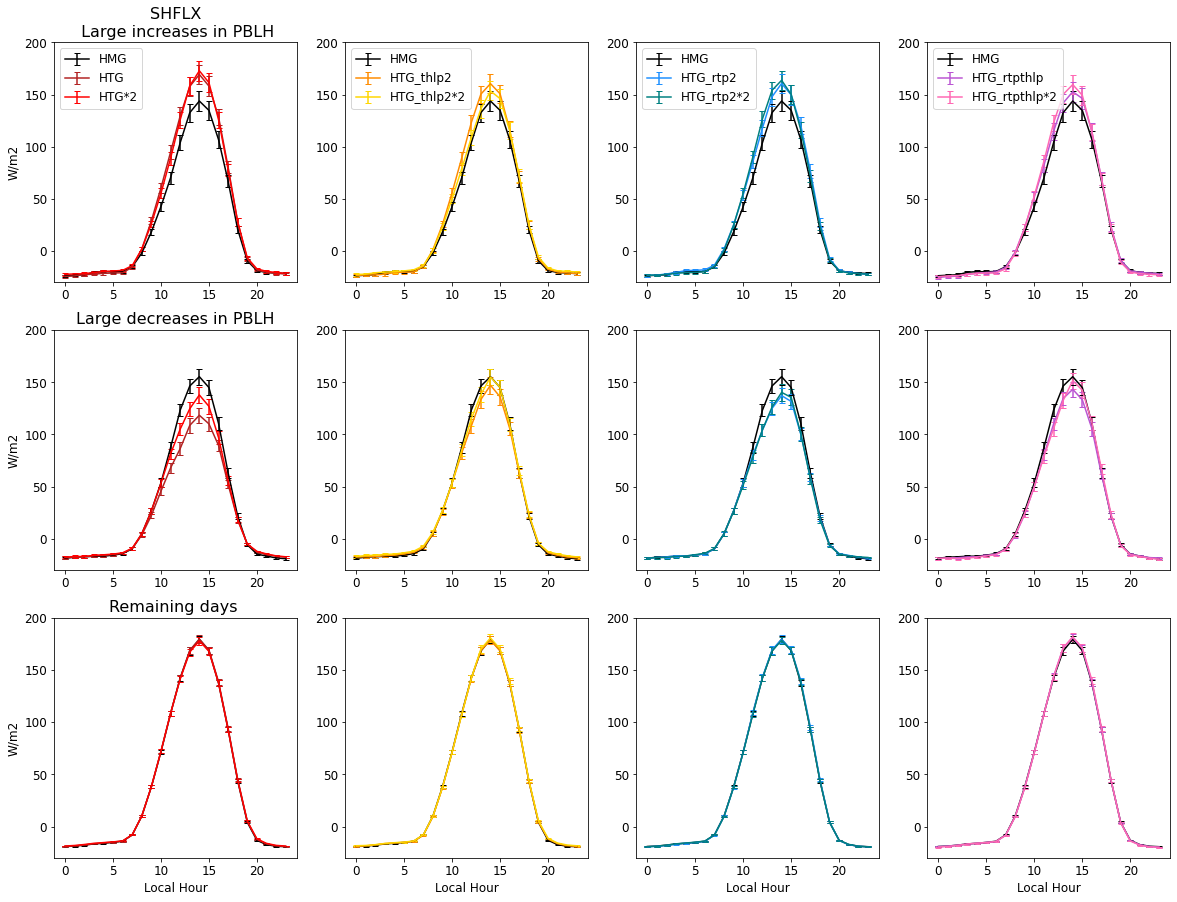

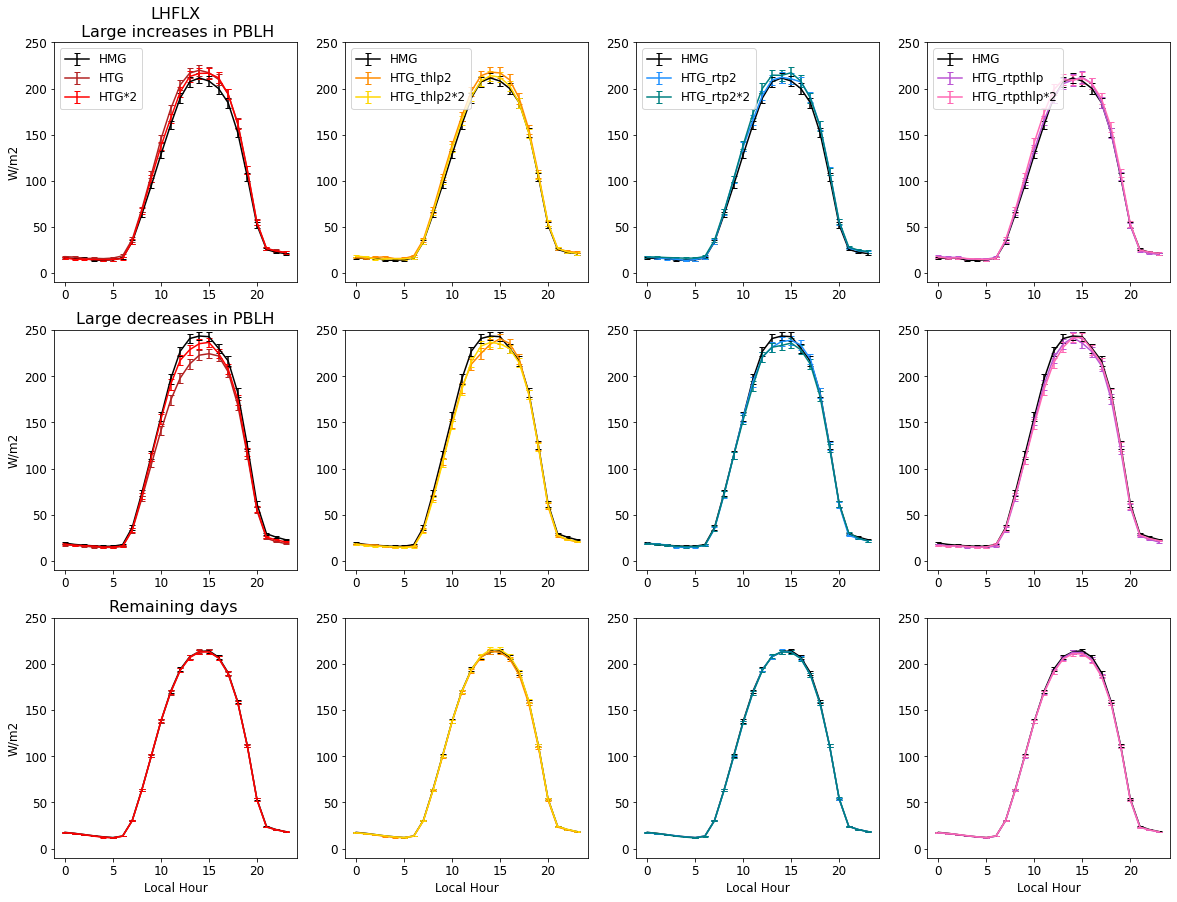

In [55]:
axs1 = plotDiurnalCycle_sensDays_multipliers('SHFLX', None, 200, -30)
axs2 = plotDiurnalCycle_sensDays_multipliers('LHFLX', None, 250, -10)


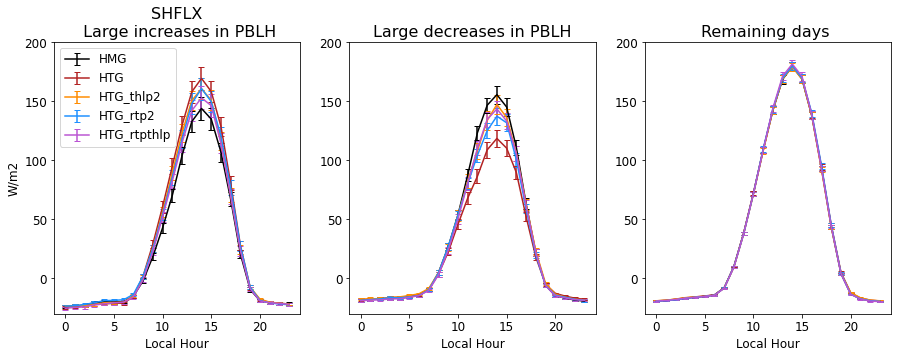

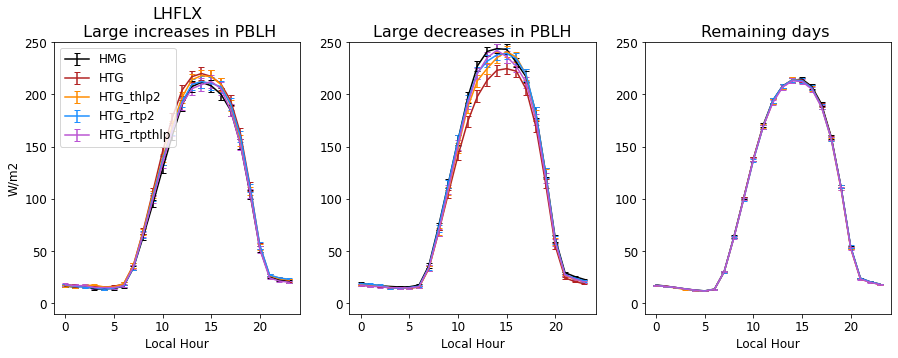

In [56]:
axs1 = plotDiurnalCycle_sensDays('SHFLX', None, 200, -30)
axs2 = plotDiurnalCycle_sensDays('LHFLX', None, 250, -10)


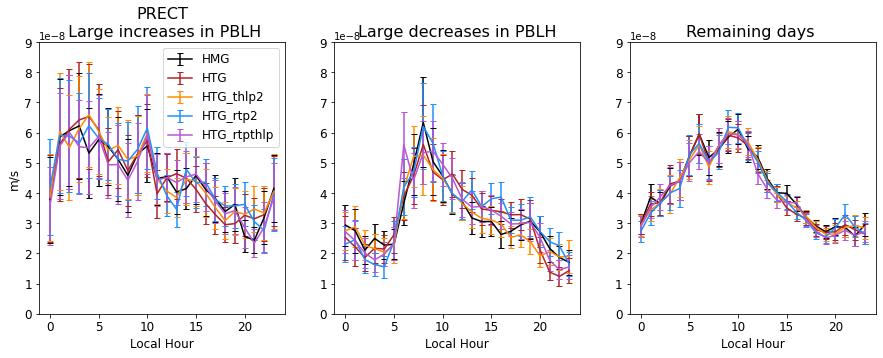

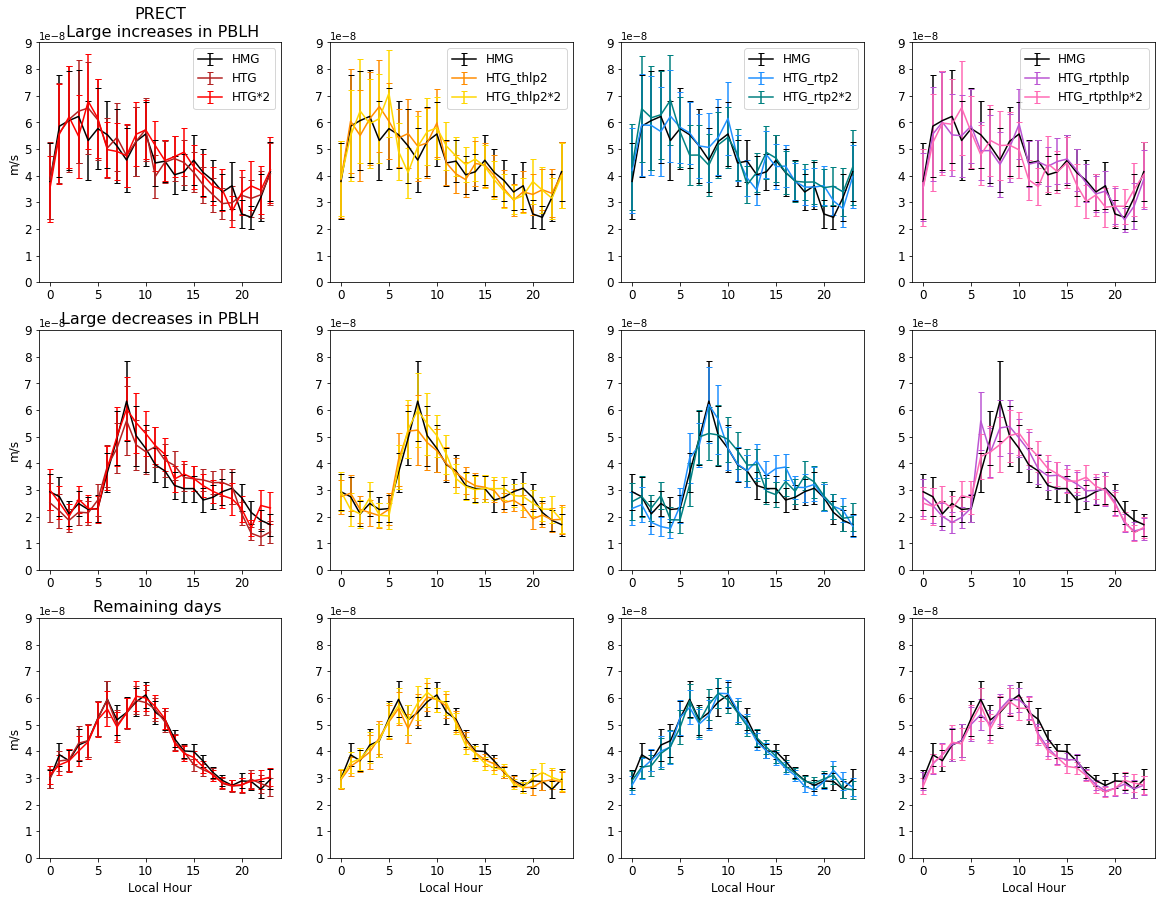

In [57]:
p1=plotDiurnalCycle_sensDays('PRECT', None, 9e-8, 0)
p2=plotDiurnalCycle_sensDays_multipliers('PRECT', None, 9e-8, 0)


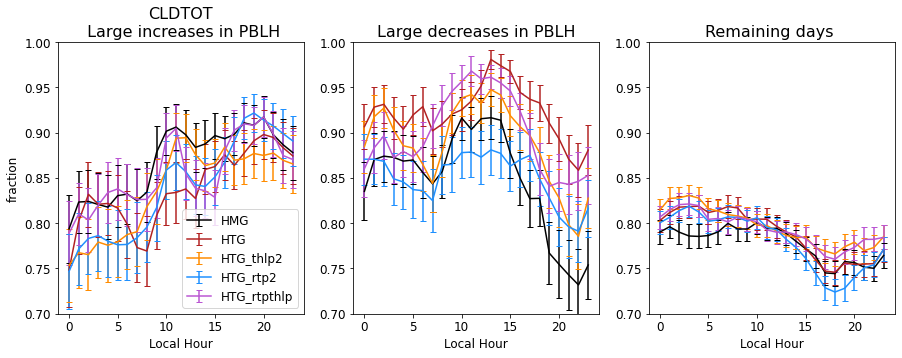

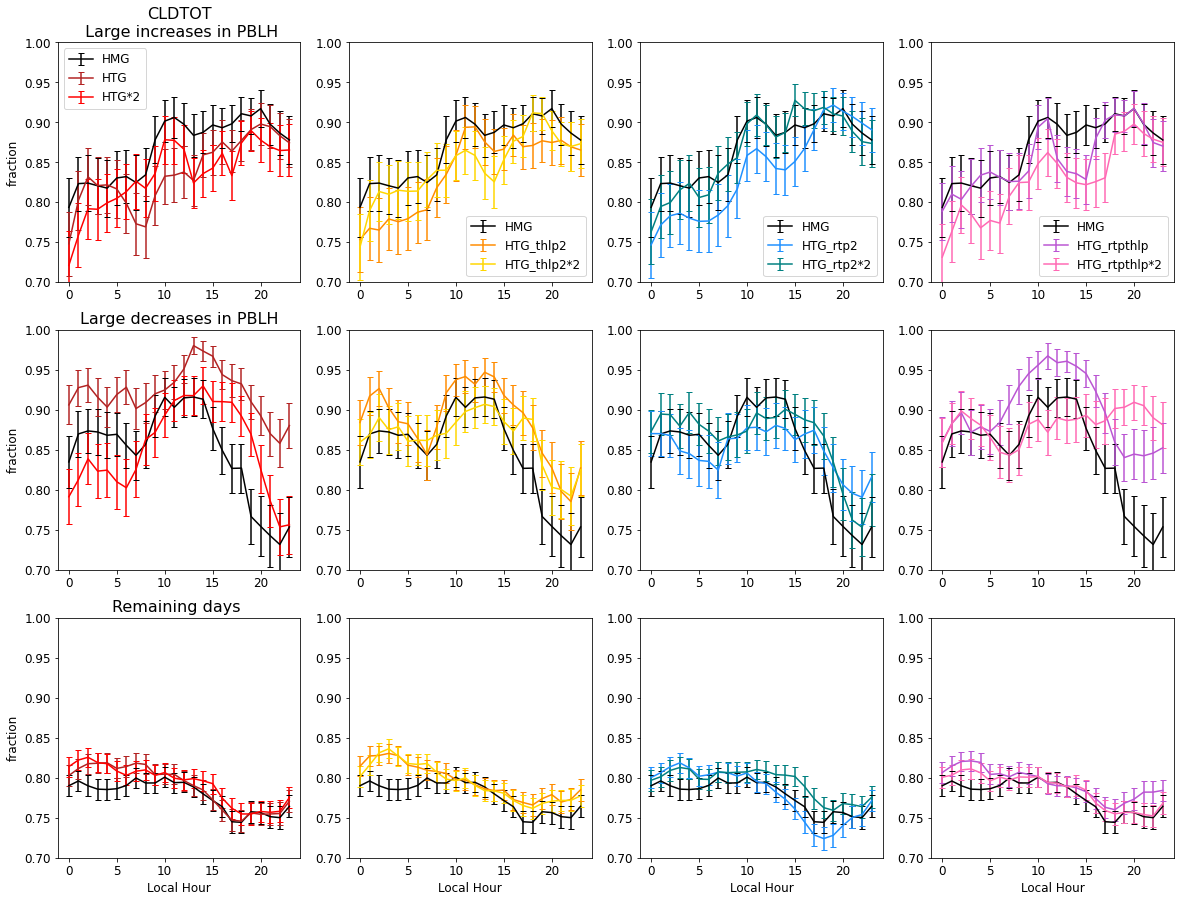

In [58]:
axs1 = plotDiurnalCycle_sensDays('CLDTOT', None, 1.0, 0.7)
axs1 = plotDiurnalCycle_sensDays_multipliers('CLDTOT', None, 1.0, 0.7)

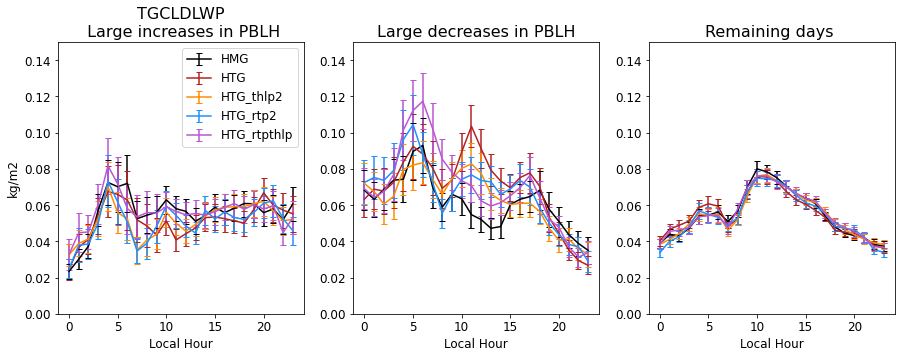

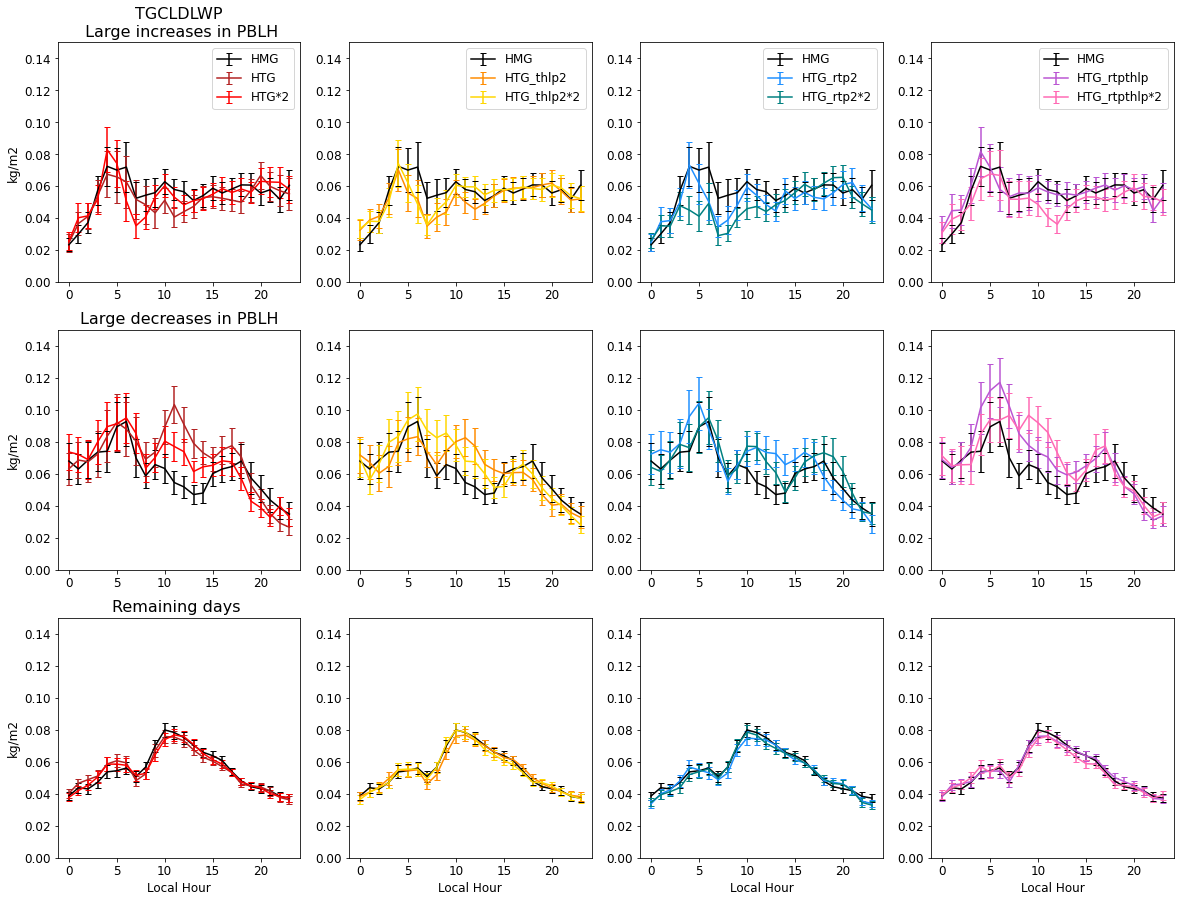

In [59]:
p1=plotDiurnalCycle_sensDays('TGCLDLWP', None, 0.15, 0)
p1=plotDiurnalCycle_sensDays_multipliers('TGCLDLWP', None, 0.15, 0)

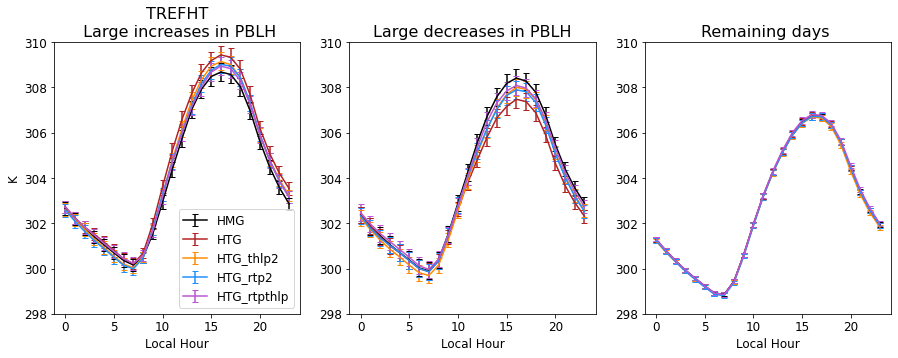

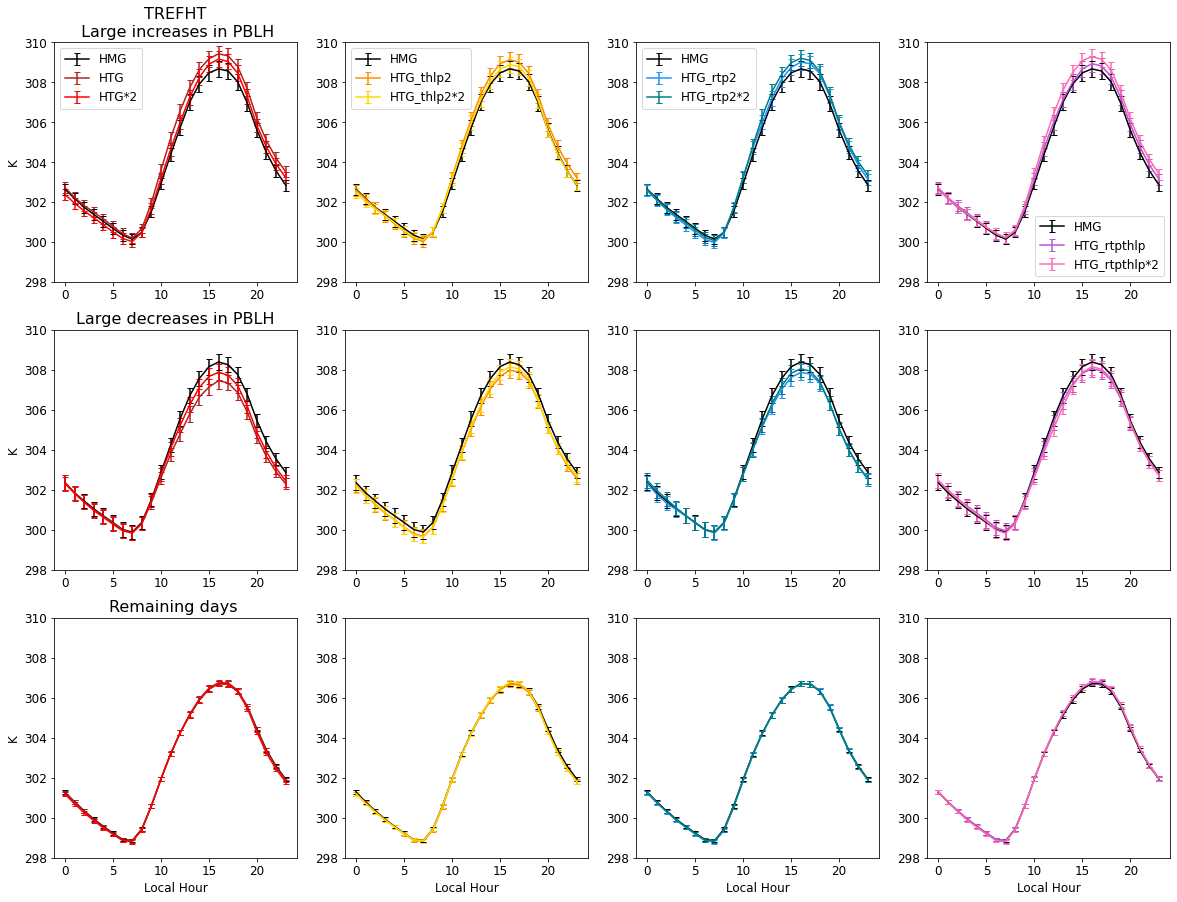

In [60]:
axs1=plotDiurnalCycle_sensDays('TREFHT', None, 310, 298)
axs1=plotDiurnalCycle_sensDays_multipliers('TREFHT', None, 310, 298)

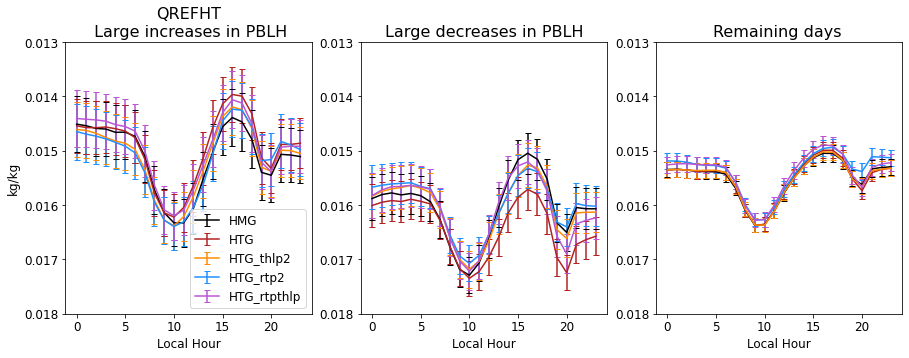

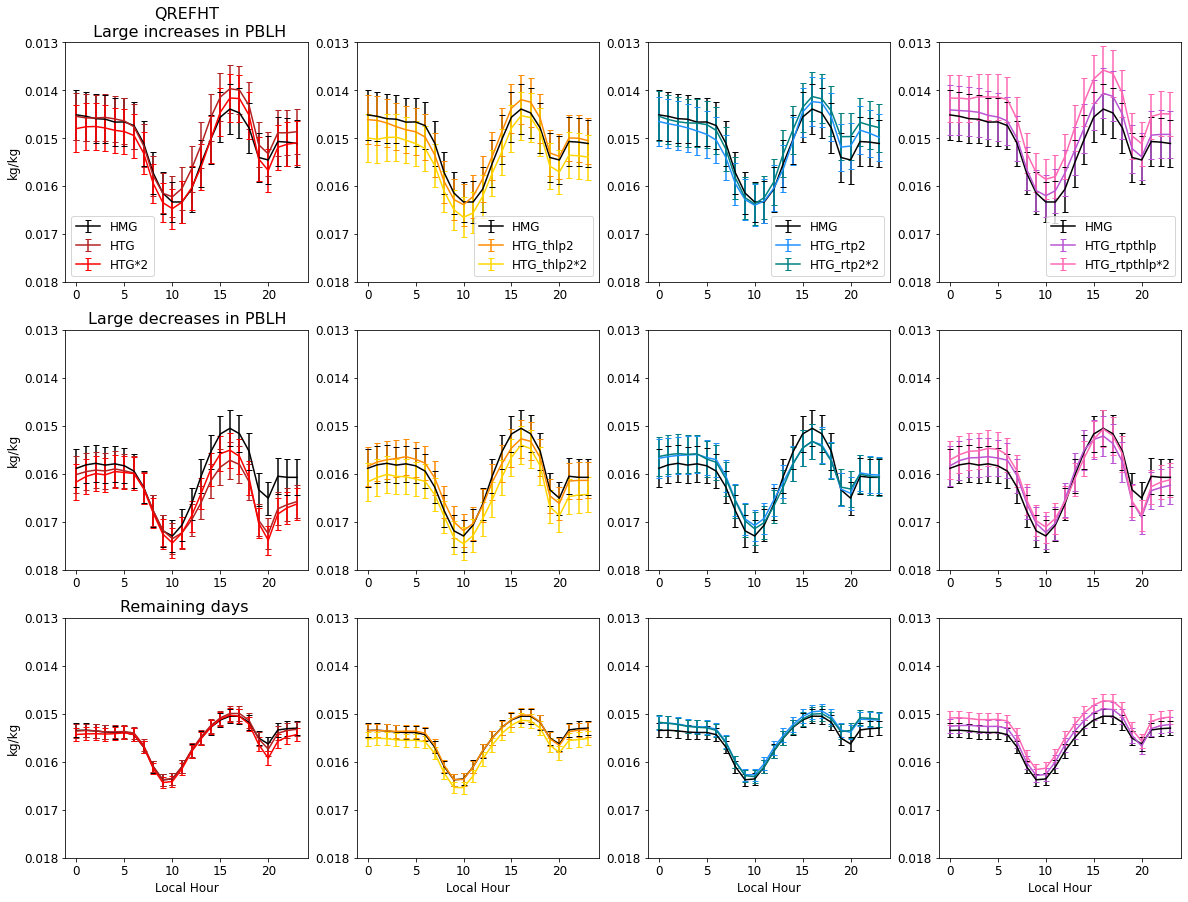

In [61]:
axs1=plotDiurnalCycle_sensDays('QREFHT', None, 0.013, 0.018)
axs1=plotDiurnalCycle_sensDays_multipliers('QREFHT', None, 0.013, 0.018)

## Plot mean profiles

In [27]:
'''
Give this plotting routine the hourly mean DS' of high/low percentile filtering
'''

def plotProfiles_meanOverHours(highPctDS, lowPctDS, restOfDaysDS,
                               varSelPlot,
                               startHr,endHr,
                               xMin, xMax, maxLev):
    
    caseNames = np.asarray(['HMG','HTG','HTG_thlp2','HTG_rtp2','HTG_rtpthlp'])
    colorList = np.asarray(['black','firebrick','darkorange','dodgerblue','mediumorchid'])

    ## Select which levels array to use
    if np.shape(highPctDS[varSelPlot].values)[2]==len(highPctDS.ilev.values):
        levSel = 'ilev'
    elif np.shape(highPctDS[varSelPlot].values)[2]==len(highPctDS.lev.values):
        levSel = 'lev'
    elif np.shape(highPctDS[varSelPlot].values)[2]==len(highPctDS.levInterp.values):
        levSel = 'levInterp'
        
        
    ## First, get means (& std) over the selected hours 
    iTimeSel_high = np.where((highPctDS["time.hour"].values>=startHr) & 
                             (highPctDS["time.hour"].values<=endHr))[0]
    iTimeSel_low  = np.where((lowPctDS["time.hour"].values>=startHr) & 
                             (lowPctDS["time.hour"].values<=endHr))[0]
    iTimeSel_rest = np.where((restOfDaysDS["time.hour"].values>=startHr) & 
                             (restOfDaysDS["time.hour"].values<=endHr))[0]
    
    
    hourlyMean_highTimeSel   = highPctDS.isel(time=iTimeSel_high).mean(dim='time')
    hourlyMean_lowTimeSel    = lowPctDS.isel(time=iTimeSel_low).mean(dim='time')
    hourlyMean_restTimeSel   = restOfDaysDS.isel(time=iTimeSel_rest).mean(dim='time')
    
    hourlyStd_highTimeSel   = highPctDS.isel(time=iTimeSel_high).std(dim='time')
    hourlyStd_lowTimeSel    = lowPctDS.isel(time=iTimeSel_low).std(dim='time')
    hourlyStd_restTimeSel   = restOfDaysDS.isel(time=iTimeSel_rest).std(dim='time')
    
    
    # Select the requested variable
    HMGvar_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HMG')[0])[varSelPlot].values)
    HMGvar_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HMG')[0])[varSelPlot].values)
    HMGvar_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case  == 'HMG')[0])[varSelPlot].values)

    HTGvar_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG')[0])[varSelPlot].values)
    HTGvar_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG')[0])[varSelPlot].values)
    HTGvar_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG')[0])[varSelPlot].values)

    HTGthlp2_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)

    HTGrtp2_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    
    HTGrtpthlp_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlp_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlp_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
    
    
    
    # Also get the std of that variable... 
    HMGvarStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyStd_highTimeSel.case == 'HMG')[0])[varSelPlot].values)
    HMGvarStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyStd_lowTimeSel.case   == 'HMG')[0])[varSelPlot].values)
    HMGvarStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyStd_restTimeSel.case  == 'HMG')[0])[varSelPlot].values)

    HTGvarStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyStd_highTimeSel.case == 'HTG')[0])[varSelPlot].values)
    HTGvarStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyStd_lowTimeSel.case   == 'HTG')[0])[varSelPlot].values)
    HTGvarStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyStd_restTimeSel.case == 'HTG')[0])[varSelPlot].values)
    
    HTGthlp2Std_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2Std_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2Std_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)

    HTGrtp2Std_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2Std_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2Std_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    
    HTGrtpthlpStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlpStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlpStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
    

    ## Set up figure
    fig,axs = plt.subplots(1,3, figsize=(15,5))
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.2)

    atmLevs = highPctDS[levSel].values


    ## - - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Plot profiles
    axs[0].errorbar(HMGvar_high,   atmLevs,
                    xerr=2*(HMGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color=colorList[0], label=caseNames[0])
    axs[0].errorbar(HTGvar_high,   atmLevs, 
                    xerr=2*(HTGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color=colorList[1], label=caseNames[1])
    axs[0].errorbar(HTGthlp2_high,   atmLevs, 
                    xerr=2*(HTGthlp2Std_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color=colorList[2], label=caseNames[2])
    axs[0].errorbar(HTGrtp2_high,   atmLevs, 
                    xerr=2*(HTGrtp2Std_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color=colorList[3], label=caseNames[3])
    axs[0].errorbar(HTGrtpthlp_high,   atmLevs, 
                    xerr=2*(HTGrtpthlpStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color=colorList[4], label=caseNames[4])
    axs[0].legend(fontsize=12)

    
    axs[1].errorbar(HMGvar_low,   atmLevs, 
                    xerr=2*(HMGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color=colorList[0], label=caseNames[0])
    axs[1].errorbar(HTGvar_low,   atmLevs,
                    xerr=2*(HTGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color=colorList[1], label=caseNames[1])
    axs[1].errorbar(HTGthlp2_low,   atmLevs,
                    xerr=2*(HTGthlp2Std_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color=colorList[2], label=caseNames[2])
    axs[1].errorbar(HTGrtp2_low,   atmLevs,
                    xerr=2*(HTGrtp2Std_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color=colorList[3], label=caseNames[3])
    axs[1].errorbar(HTGrtpthlp_low,   atmLevs,
                    xerr=2*(HTGrtpthlpStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color=colorList[4], label=caseNames[4])
                    
                     
    axs[2].errorbar(HMGvar_rest,   atmLevs,
                    xerr=2*(HMGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color=colorList[0], label=caseNames[0])
    axs[2].errorbar(HTGvar_rest,   atmLevs, 
                    xerr=2*(HTGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color=colorList[1], label=caseNames[1])
    axs[2].errorbar(HTGthlp2_rest,   atmLevs, 
                    xerr=2*(HTGthlp2Std_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color=colorList[2], label=caseNames[2])
    axs[2].errorbar(HTGrtp2_rest,   atmLevs, 
                    xerr=2*(HTGrtp2Std_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color=colorList[3], label=caseNames[3])
    axs[2].errorbar(HTGrtpthlp_rest,   atmLevs, 
                    xerr=2*(HTGrtpthlpStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color=colorList[4], label=caseNames[4])    

    ## - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Other plot options
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()

    axs[0].set_ylim([980, maxLev])
    axs[1].set_ylim([980, maxLev])
    axs[2].set_ylim([980, maxLev])
    
    axs[0].set_xlim([xMin, xMax])
    axs[1].set_xlim([xMin, xMax])
    axs[2].set_xlim([xMin, xMax])
    
    axs[1].axes.yaxis.set_ticklabels([])
    axs[2].axes.yaxis.set_ticklabels([])   

    axs[0].set_title(varSelPlot+'\n Large increases in '+varSel, fontsize=16)       
    axs[1].set_title('Large decreases in '+varSel, fontsize=16)
    axs[2].set_title('Remaining days', fontsize=16)

    axs[0].set_xlabel(realSfc_allCases[varSelPlot].units, fontsize=12)
    axs[1].set_xlabel(realSfc_allCases[varSelPlot].units, fontsize=12)
    axs[2].set_xlabel(realSfc_allCases[varSelPlot].units, fontsize=12)
    
    if varSelPlot.endswith('_interp'):
        axs[0].set_ylabel('hPa', fontsize=12)
    else:
        axs[0].set_ylabel('hPa (model hybrid coord)', fontsize=12)

    axs[0].tick_params(axis='both', labelsize= 12)
    axs[1].tick_params(axis='both', labelsize= 12)
    axs[2].tick_params(axis='both', labelsize= 12)

    return

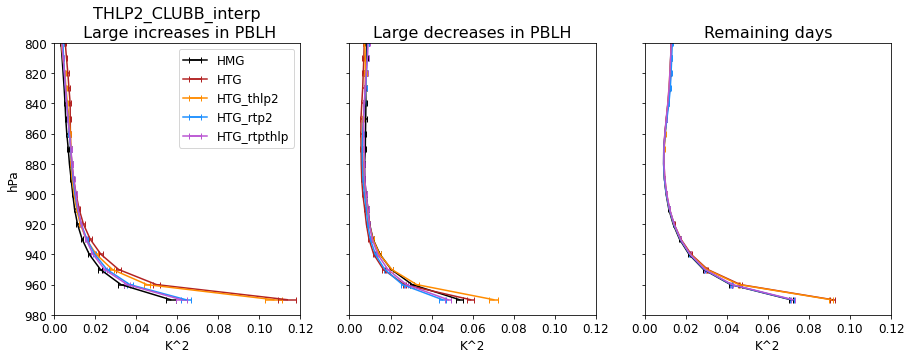

In [27]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'THLP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           0.12,     # Max x value
                           800)     # Max level 


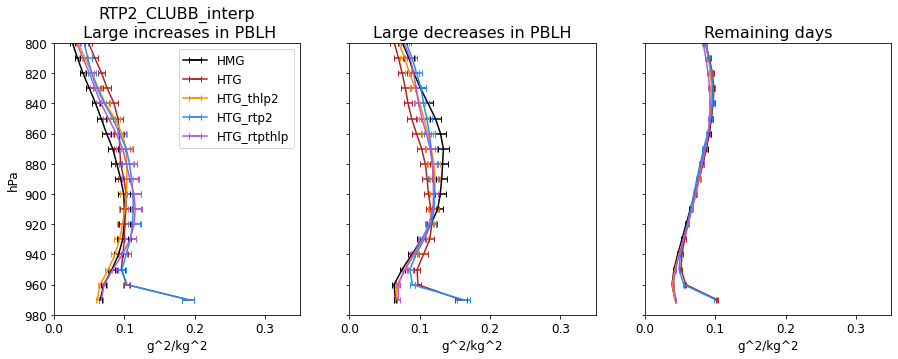

In [70]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'RTP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           0.35,     # Max x value
                           800)     # Max level 


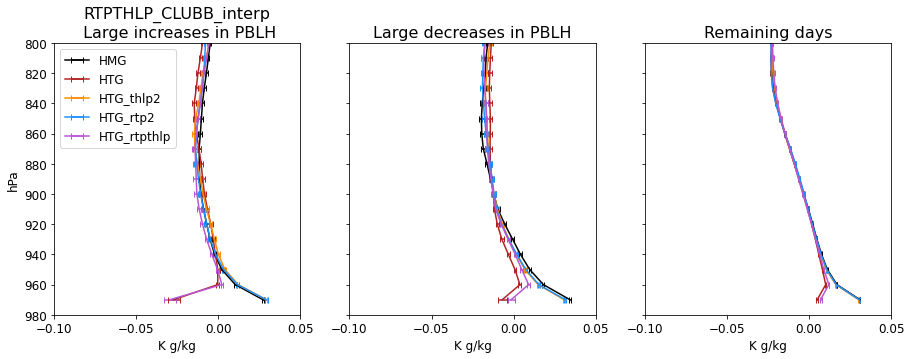

In [71]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'RTPTHLP_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           -0.1,       # Min x value
                           0.05,     # Max x value
                           800)     # Max level 


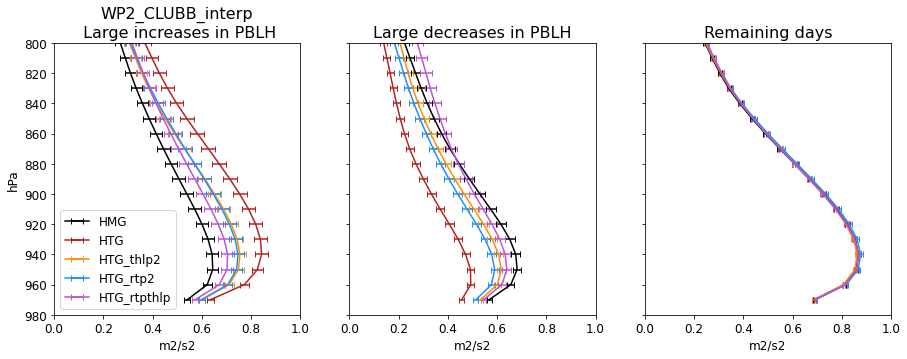

In [72]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'WP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           1.0,     # Max x value
                           800)     # Max level


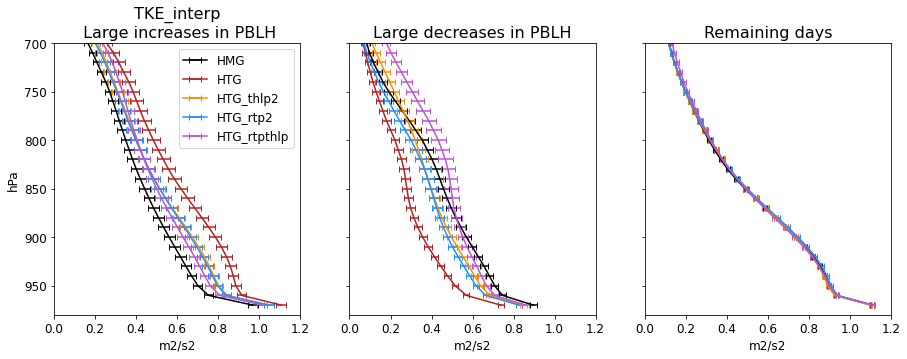

In [73]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'TKE_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           1.2,     # Max x value
                           700)     # Max level 


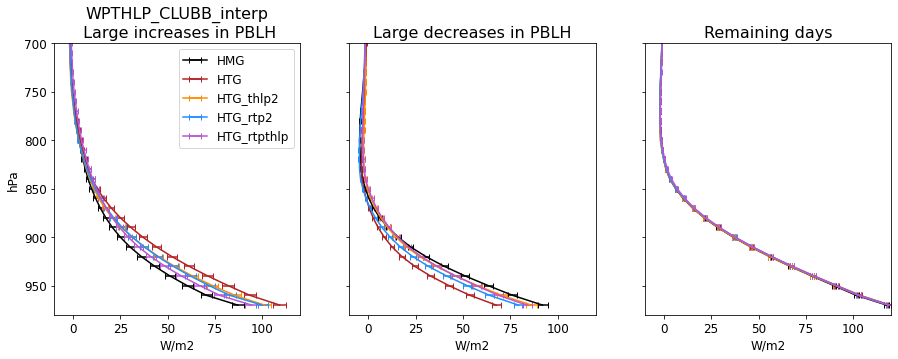

In [74]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'WPTHLP_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           -10,       # Min x value
                           120,     # Max x value
                           700)     # Max level 


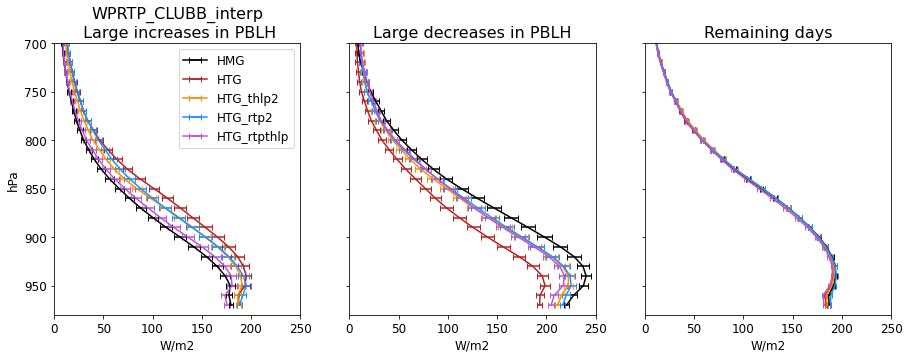

In [75]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'WPRTP_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           250,     # Max x value
                           700)     # Max level 


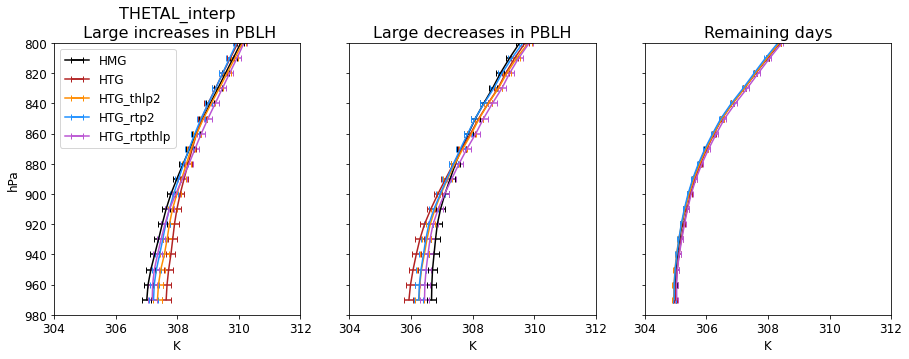

In [76]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'THETAL_interp',
                           12, 18,  # Start hr, end hr
                           304,     # Min x value
                           312,     # Max x value
                           800)     # Max level 


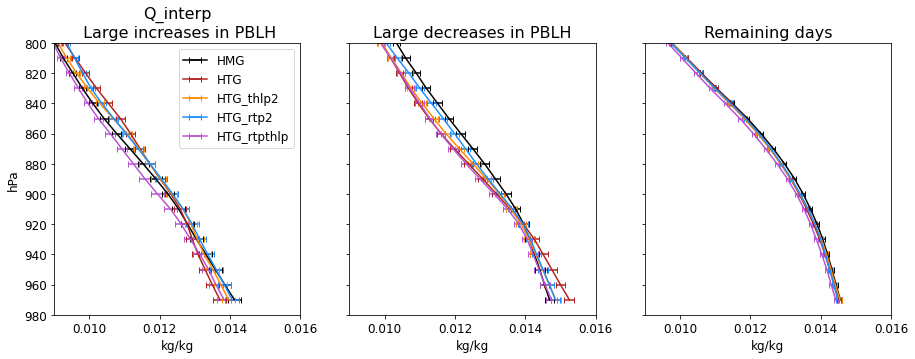

In [77]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'Q_interp',
                           12, 18,  # Start hr, end hr
                           0.009,     # Min x value
                           0.016,     # Max x value
                           800)     # Max level 


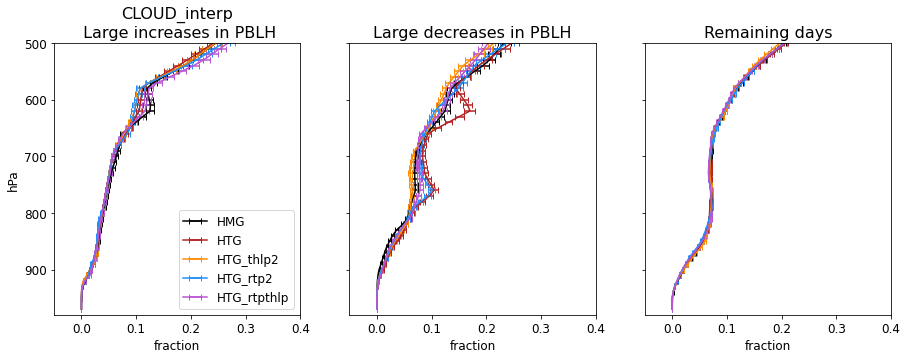

In [78]:
plotProfiles_meanOverHours(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'CLOUD_interp',
                           12, 18,  # Start hr, end hr
                           -0.05,     # Min x value
                           0.4,     # Max x value
                           500)     # Max level 


In [28]:
'''
Give this plotting routine the hourly mean DS' of high/low percentile filtering
'''

def plotProfiles_meanOverHours_multipliers(highPctDS, lowPctDS, restOfDaysDS,
                               varSelPlot,
                               startHr,endHr,
                               xMin, xMax, maxLev):
    
    caseNames = np.asarray(['HMG','HTG','HTG_thlp2','HTG_rtp2','HTG_rtpthlp'])
    colorList = np.asarray(['black','firebrick','darkorange','dodgerblue','mediumorchid'])

    ## Select which levels array to use
    if np.shape(highPctDS[varSelPlot].values)[2]==len(highPctDS.ilev.values):
        levSel = 'ilev'
    elif np.shape(highPctDS[varSelPlot].values)[2]==len(highPctDS.lev.values):
        levSel = 'lev'
    elif np.shape(highPctDS[varSelPlot].values)[2]==len(highPctDS.levInterp.values):
        levSel = 'levInterp'
        
        
    ## First, get means (& std) over the selected hours 
    iTimeSel_high = np.where((highPctDS["time.hour"].values>=startHr) & 
                             (highPctDS["time.hour"].values<=endHr))[0]
    iTimeSel_low  = np.where((lowPctDS["time.hour"].values>=startHr) & 
                             (lowPctDS["time.hour"].values<=endHr))[0]
    iTimeSel_rest = np.where((restOfDaysDS["time.hour"].values>=startHr) & 
                             (restOfDaysDS["time.hour"].values<=endHr))[0]
    
    
    hourlyMean_highTimeSel   = highPctDS.isel(time=iTimeSel_high).mean(dim='time')
    hourlyMean_lowTimeSel    = lowPctDS.isel(time=iTimeSel_low).mean(dim='time')
    hourlyMean_restTimeSel   = restOfDaysDS.isel(time=iTimeSel_rest).mean(dim='time')
    
    hourlyStd_highTimeSel   = highPctDS.isel(time=iTimeSel_high).std(dim='time')
    hourlyStd_lowTimeSel    = lowPctDS.isel(time=iTimeSel_low).std(dim='time')
    hourlyStd_restTimeSel   = restOfDaysDS.isel(time=iTimeSel_rest).std(dim='time')
    
    
    # Select the requested variable
    HMGvar_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HMG')[0])[varSelPlot].values)
    HMGvar_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HMG')[0])[varSelPlot].values)
    HMGvar_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case  == 'HMG')[0])[varSelPlot].values)

    HTGvar_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG')[0])[varSelPlot].values)
    HTGvar_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG')[0])[varSelPlot].values)
    HTGvar_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG')[0])[varSelPlot].values)
    
    HTG2var_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG*2')[0])[varSelPlot].values)
    HTG2var_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG*2')[0])[varSelPlot].values)
    HTG2var_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG*2')[0])[varSelPlot].values)

    HTGthlp2_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)

    HTGrtp2_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    
    HTGrtpthlp_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlp_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlp_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
    
    HTG2thlp2_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_thlp2*2')[0])[varSelPlot].values)
    HTG2thlp2_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_thlp2*2')[0])[varSelPlot].values)
    HTG2thlp2_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_thlp2*2')[0])[varSelPlot].values)

    HTG2rtp2_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtp2*2')[0])[varSelPlot].values)
    HTG2rtp2_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtp2*2')[0])[varSelPlot].values)
    HTG2rtp2_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtp2*2')[0])[varSelPlot].values)
    
    HTG2rtpthlp_high   = np.squeeze(hourlyMean_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtpthlp*2')[0])[varSelPlot].values)
    HTG2rtpthlp_low    = np.squeeze(hourlyMean_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtpthlp*2')[0])[varSelPlot].values)
    HTG2rtpthlp_rest   = np.squeeze(hourlyMean_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtpthlp*2')[0])[varSelPlot].values)
    
    
    
    # Also get the std of that variable... 
    HMGvarStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyStd_highTimeSel.case == 'HMG')[0])[varSelPlot].values)
    HMGvarStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyStd_lowTimeSel.case   == 'HMG')[0])[varSelPlot].values)
    HMGvarStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyStd_restTimeSel.case  == 'HMG')[0])[varSelPlot].values)

    HTGvarStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyStd_highTimeSel.case == 'HTG')[0])[varSelPlot].values)
    HTGvarStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyStd_lowTimeSel.case   == 'HTG')[0])[varSelPlot].values)
    HTGvarStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyStd_restTimeSel.case == 'HTG')[0])[varSelPlot].values)

    HTG2varStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyStd_highTimeSel.case == 'HTG*2')[0])[varSelPlot].values)
    HTG2varStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyStd_lowTimeSel.case   == 'HTG*2')[0])[varSelPlot].values)
    HTG2varStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyStd_restTimeSel.case == 'HTG*2')[0])[varSelPlot].values)
    
    HTGthlp2Std_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2Std_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_thlp2')[0])[varSelPlot].values)
    HTGthlp2Std_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_thlp2')[0])[varSelPlot].values)

    HTGrtp2Std_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2Std_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtp2')[0])[varSelPlot].values)
    HTGrtp2Std_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtp2')[0])[varSelPlot].values)
    
    HTGrtpthlpStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlpStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtpthlp')[0])[varSelPlot].values)
    HTGrtpthlpStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtpthlp')[0])[varSelPlot].values)
        
    HTG2thlp2Std_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_thlp2*2')[0])[varSelPlot].values)
    HTG2thlp2Std_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_thlp2*2')[0])[varSelPlot].values)
    HTG2thlp2Std_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_thlp2*2')[0])[varSelPlot].values)

    HTG2rtp2Std_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtp2*2')[0])[varSelPlot].values)
    HTG2rtp2Std_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtp2*2')[0])[varSelPlot].values)
    HTG2rtp2Std_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtp2*2')[0])[varSelPlot].values)
    
    HTG2rtpthlpStd_high   = np.squeeze(hourlyStd_highTimeSel.isel(case=np.where(hourlyMean_highTimeSel.case == 'HTG_rtpthlp*2')[0])[varSelPlot].values)
    HTG2rtpthlpStd_low    = np.squeeze(hourlyStd_lowTimeSel.isel(case=np.where(hourlyMean_lowTimeSel.case   == 'HTG_rtpthlp*2')[0])[varSelPlot].values)
    HTG2rtpthlpStd_rest   = np.squeeze(hourlyStd_restTimeSel.isel(case=np.where(hourlyMean_restTimeSel.case == 'HTG_rtpthlp*2')[0])[varSelPlot].values)

    ## Set up figure
    fig,axs = plt.subplots(3,4, figsize=(20,15))
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.2)

    atmLevs = highPctDS[levSel].values


    ## - - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Plot profiles
    
    # High pct days 
    axs[0].errorbar(HMGvar_high,   atmLevs,
                    xerr=2*(HMGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='k', label='HMG')
    axs[0].errorbar(HTGvar_high,   atmLevs, 
                    xerr=2*(HTGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='firebrick', label='HTG')
    axs[0].errorbar(HTG2var_high,   atmLevs, 
                    xerr=2*(HTG2varStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='red', label='HTG*2')   
    
    axs[1].errorbar(HMGvar_high,   atmLevs,
                    xerr=2*(HMGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='k', label='HMG')
    axs[1].errorbar(HTGthlp2_high,   atmLevs, 
                    xerr=2*(HTGthlp2Std_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='darkorange', label='HTG_thlp2')
    axs[1].errorbar(HTG2thlp2_high,   atmLevs, 
                    xerr=2*(HTG2thlp2Std_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='gold', label='HTG_thlp2*2')   
    
    axs[2].errorbar(HMGvar_high,   atmLevs,
                    xerr=2*(HMGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='k', label='HMG')
    axs[2].errorbar(HTGrtp2_high,   atmLevs, 
                    xerr=2*(HTGrtp2Std_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='dodgerblue', label='HTG_rtp2')
    axs[2].errorbar(HTG2rtp2_high,   atmLevs, 
                    xerr=2*(HTG2rtp2Std_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='teal', label='HTG_rtp2')    
    
    axs[3].errorbar(HMGvar_high,   atmLevs,
                    xerr=2*(HMGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='k', label='HMG')
    axs[3].errorbar(HTGrtpthlp_high,   atmLevs, 
                    xerr=2*(HTGrtpthlpStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='mediumorchid', label='HTG_rtpthlp')
    axs[3].errorbar(HTG2rtpthlp_high,   atmLevs, 
                    xerr=2*(HTG2rtpthlpStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color='hotpink', label='HTG_rtpthlp*2')
    
    axs[0].legend(fontsize=12)
    axs[1].legend(fontsize=12)
    axs[2].legend(fontsize=12)
    axs[3].legend(fontsize=12)

    # --------------------------------------------------------------------------------
    #  Low Pct days
   
    axs[4].errorbar(HMGvar_low,   atmLevs,
                    xerr=2*(HMGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='k', label='HMG')
    axs[4].errorbar(HTGvar_low,   atmLevs, 
                    xerr=2*(HTGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='firebrick', label='HTG')
    axs[4].errorbar(HTG2var_low,   atmLevs, 
                    xerr=2*(HTG2varStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='red', label='HTG*2')   
    
    axs[5].errorbar(HMGvar_low,   atmLevs,
                    xerr=2*(HMGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='k', label='HMG')
    axs[5].errorbar(HTGthlp2_low,   atmLevs, 
                    xerr=2*(HTGthlp2Std_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='darkorange', label='HTG_thlp2')
    axs[5].errorbar(HTG2thlp2_low,   atmLevs, 
                    xerr=2*(HTG2thlp2Std_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='gold', label='HTG_thlp2*2')   
    
    axs[6].errorbar(HMGvar_low,   atmLevs,
                    xerr=2*(HMGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='k', label='HMG')
    axs[6].errorbar(HTGrtp2_low,   atmLevs, 
                    xerr=2*(HTGrtp2Std_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='dodgerblue', label='HTG_rtp2')
    axs[6].errorbar(HTG2rtp2_low,   atmLevs, 
                    xerr=2*(HTG2rtp2Std_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='teal', label='HTG_rtp2')    
    
    axs[7].errorbar(HMGvar_low,   atmLevs,
                    xerr=2*(HMGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='k', label='HMG')
    axs[7].errorbar(HTGrtpthlp_low,   atmLevs, 
                    xerr=2*(HTGrtpthlpStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='mediumorchid', label='HTG_rtpthlp')
    axs[7].errorbar(HTG2rtpthlp_low,   atmLevs, 
                    xerr=2*(HTG2rtpthlpStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color='hotpink', label='HTG_rtpthlp*2')
    
    
    # --------------------------------------------------------------------------------
         
    #  Rest of days 
    
       
    axs[8].errorbar(HMGvar_rest,   atmLevs,
                    xerr=2*(HMGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='k', label='HMG')
    axs[8].errorbar(HTGvar_rest,   atmLevs, 
                    xerr=2*(HTGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='firebrick', label='HTG')
    axs[8].errorbar(HTG2var_rest,   atmLevs, 
                    xerr=2*(HTG2varStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='red', label='HTG*2')   
    
    axs[9].errorbar(HMGvar_rest,   atmLevs,
                    xerr=2*(HMGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='k', label='HMG')
    axs[9].errorbar(HTGthlp2_rest,   atmLevs, 
                    xerr=2*(HTGthlp2Std_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='darkorange', label='HTG_thlp2')
    axs[9].errorbar(HTG2thlp2_rest,   atmLevs, 
                    xerr=2*(HTG2thlp2Std_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='gold', label='HTG_thlp2*2')   
    
    axs[10].errorbar(HMGvar_rest,   atmLevs,
                    xerr=2*(HMGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='k', label='HMG')
    axs[10].errorbar(HTGrtp2_rest,   atmLevs, 
                    xerr=2*(HTGrtp2Std_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='dodgerblue', label='HTG_rtp2')
    axs[10].errorbar(HTG2rtp2_rest,   atmLevs, 
                    xerr=2*(HTG2rtp2Std_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='teal', label='HTG_rtp2')    
    
    axs[11].errorbar(HMGvar_rest,   atmLevs,
                    xerr=2*(HMGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='k', label='HMG')
    axs[11].errorbar(HTGrtpthlp_rest,   atmLevs, 
                    xerr=2*(HTGrtpthlpStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='mediumorchid', label='HTG_rtpthlp')
    axs[11].errorbar(HTG2rtpthlp_rest,   atmLevs, 
                    xerr=2*(HTG2rtpthlpStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color='hotpink', label='HTG_rtpthlp*2')
       

    ## - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Other plot options
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()
    axs[9].invert_yaxis()
    axs[10].invert_yaxis()
    axs[11].invert_yaxis()
    
    axs[0].set_ylim([980, maxLev])
    axs[1].set_ylim([980, maxLev])
    axs[2].set_ylim([980, maxLev])
    axs[3].set_ylim([980, maxLev])
    axs[4].set_ylim([980, maxLev])
    axs[5].set_ylim([980, maxLev])
    axs[6].set_ylim([980, maxLev])
    axs[7].set_ylim([980, maxLev])
    axs[8].set_ylim([980, maxLev])
    axs[9].set_ylim([980, maxLev])
    axs[10].set_ylim([980, maxLev])
    axs[11].set_ylim([980, maxLev])
    
    axs[0].set_xlim([xMin, xMax])
    axs[1].set_xlim([xMin, xMax])
    axs[2].set_xlim([xMin, xMax])
    axs[3].set_xlim([xMin, xMax])
    axs[4].set_xlim([xMin, xMax])
    axs[5].set_xlim([xMin, xMax])
    axs[6].set_xlim([xMin, xMax])
    axs[7].set_xlim([xMin, xMax])
    axs[8].set_xlim([xMin, xMax])
    axs[9].set_xlim([xMin, xMax])
    axs[10].set_xlim([xMin, xMax])
    axs[11].set_xlim([xMin, xMax])
    
    axs[1].axes.yaxis.set_ticklabels([])
    axs[2].axes.yaxis.set_ticklabels([])   
    axs[3].axes.yaxis.set_ticklabels([])  
    axs[5].axes.yaxis.set_ticklabels([])  
    axs[6].axes.yaxis.set_ticklabels([])  
    axs[7].axes.yaxis.set_ticklabels([])  
    axs[9].axes.yaxis.set_ticklabels([])  
    axs[10].axes.yaxis.set_ticklabels([])  
    axs[11].axes.yaxis.set_ticklabels([])  
    
    axs[0].set_title(varSelPlot+'\n Large increases in '+varSel, fontsize=16)       
    axs[4].set_title('Large decreases in '+varSel, fontsize=16)
    axs[8].set_title('Remaining days', fontsize=16)

    axs[8].set_xlabel(realSfc_allCases[varSelPlot].units, fontsize=12)
    axs[9].set_xlabel(realSfc_allCases[varSelPlot].units, fontsize=12)
    axs[10].set_xlabel(realSfc_allCases[varSelPlot].units, fontsize=12)
    axs[11].set_xlabel(realSfc_allCases[varSelPlot].units, fontsize=12)   
    
    if varSelPlot.endswith('_interp'):
        axs[0].set_ylabel('hPa', fontsize=12)
        axs[4].set_ylabel('hPa', fontsize=12)
        axs[8].set_ylabel('hPa', fontsize=12)
    else:
        axs[0].set_ylabel('hPa (model hybrid coord)', fontsize=12)
        axs[4].set_ylabel('hPa (model hybrid coord)', fontsize=12)
        axs[8].set_ylabel('hPa (model hybrid coord)', fontsize=12)

    axs[0].tick_params(axis='both', labelsize= 12)
    axs[1].tick_params(axis='both', labelsize= 12)
    axs[2].tick_params(axis='both', labelsize= 12)
    axs[3].tick_params(axis='both', labelsize= 12)
    axs[4].tick_params(axis='both', labelsize= 12)
    axs[5].tick_params(axis='both', labelsize= 12)
    axs[6].tick_params(axis='both', labelsize= 12)
    axs[7].tick_params(axis='both', labelsize= 12)
    axs[8].tick_params(axis='both', labelsize= 12)
    axs[9].tick_params(axis='both', labelsize= 12)
    axs[10].tick_params(axis='both', labelsize= 12)
    axs[11].tick_params(axis='both', labelsize= 12)

    return

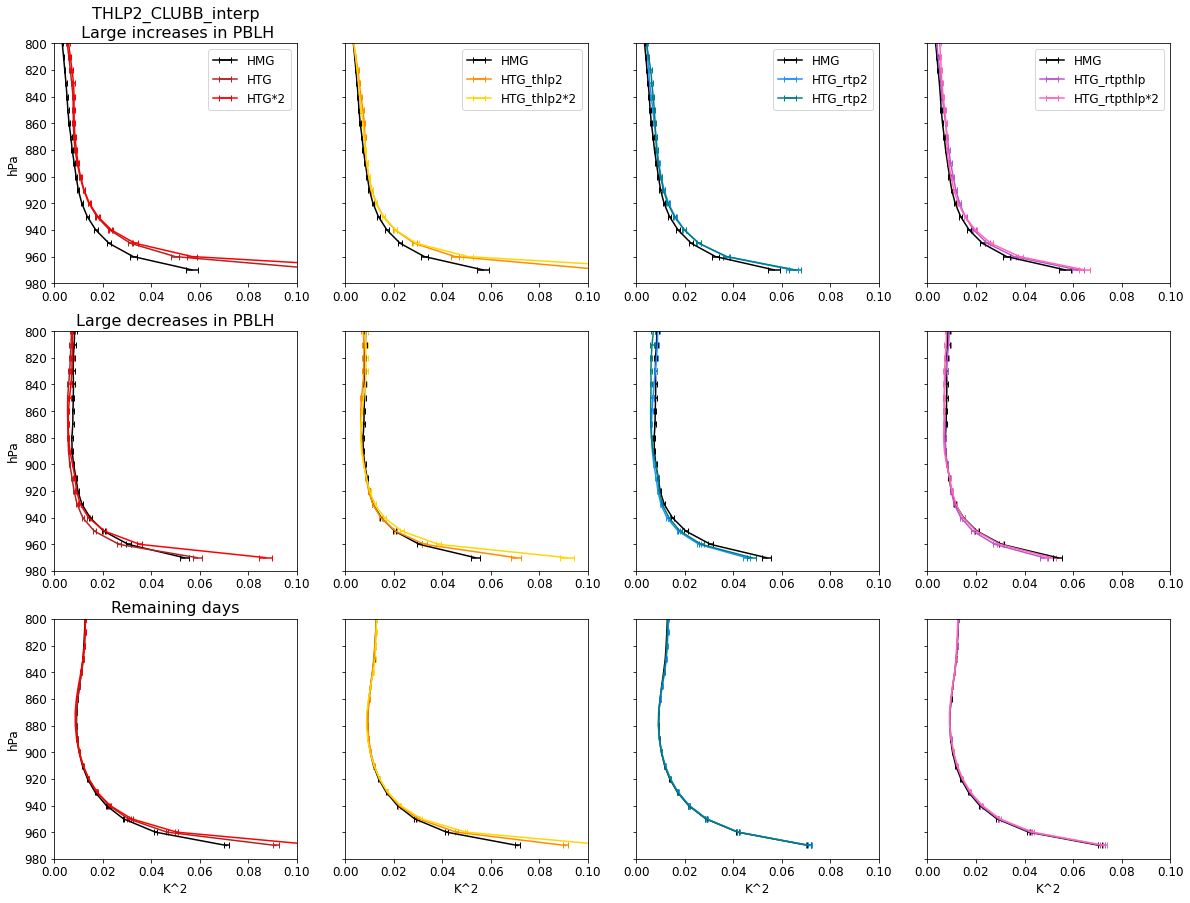

In [29]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'THLP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           0.1,     # Max x value
                           800)     # Max level 


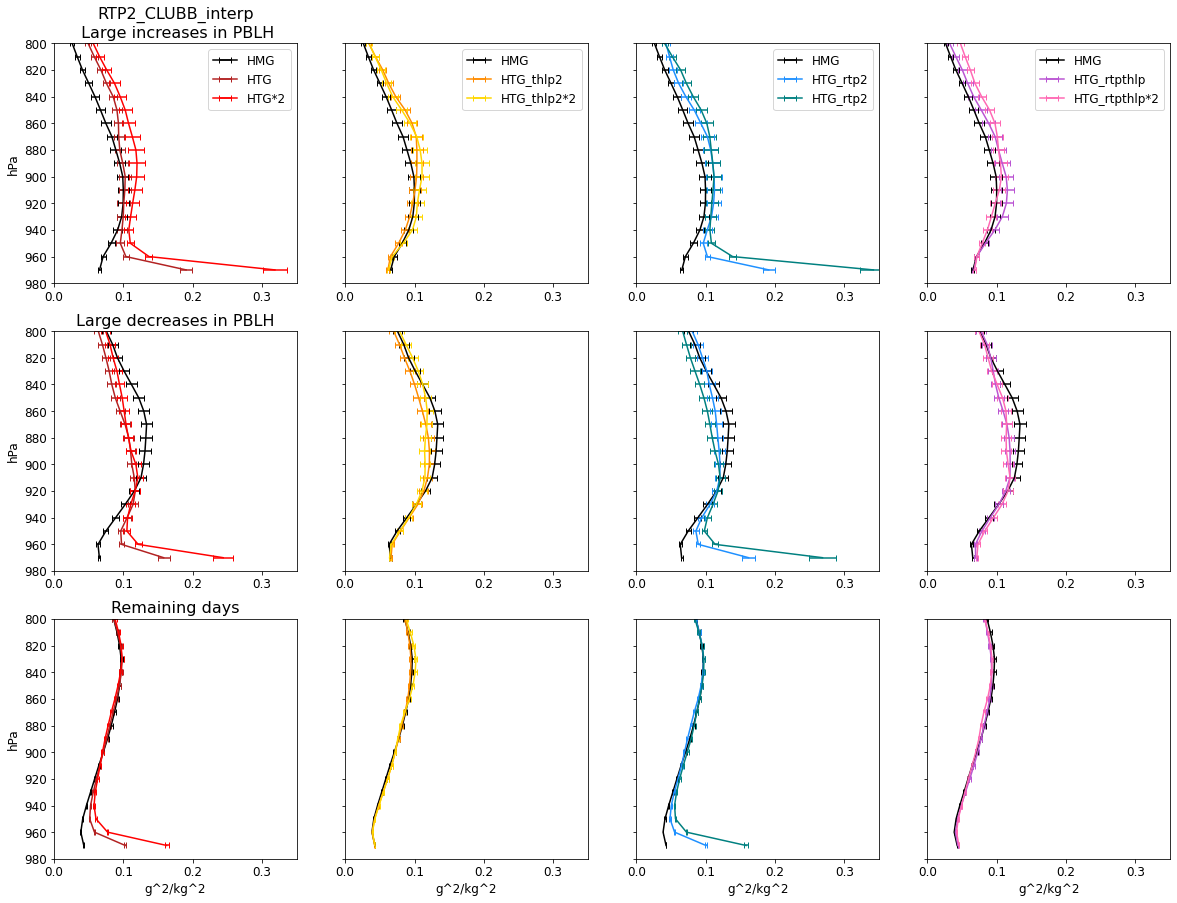

In [81]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'RTP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           0.35,     # Max x value
                           800)     # Max level 


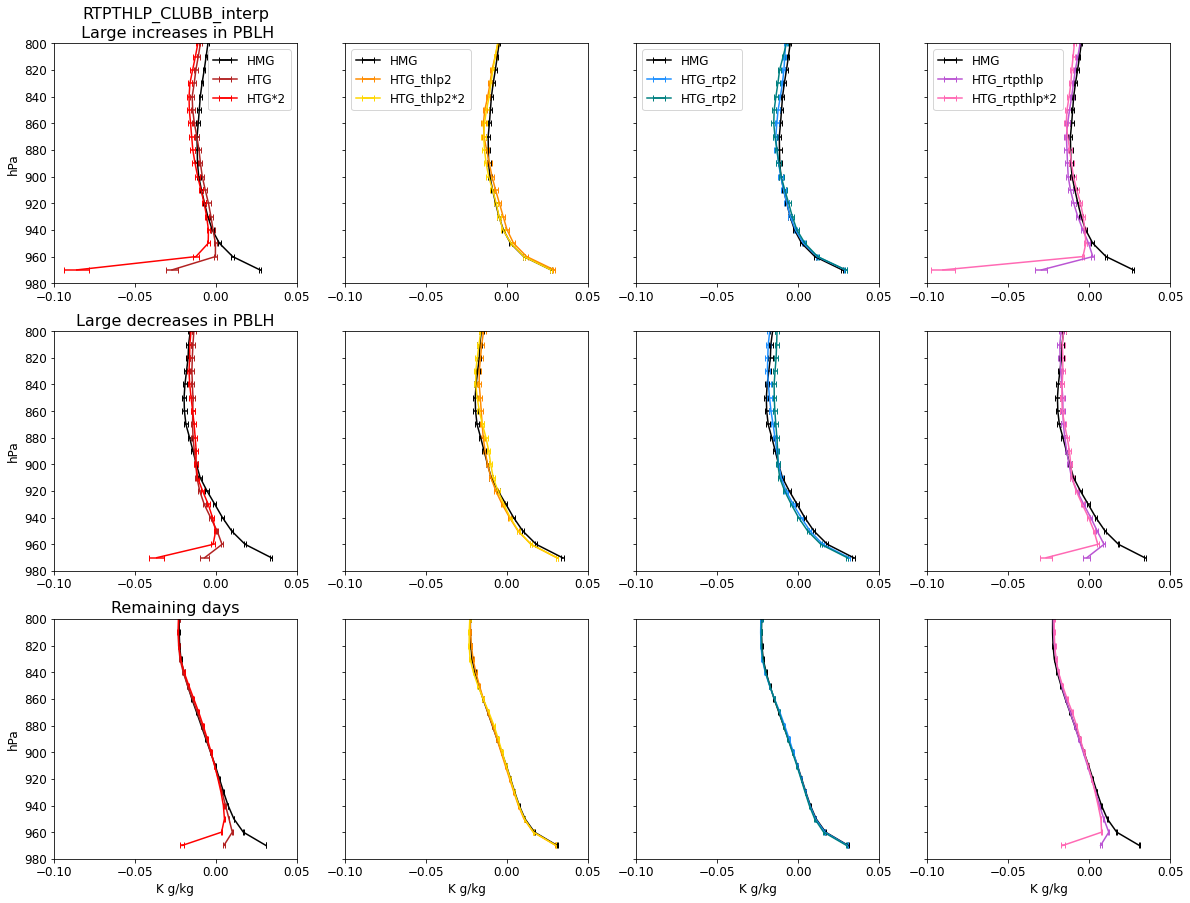

In [82]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'RTPTHLP_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           -0.1,       # Min x value
                           0.05,     # Max x value
                           800)     # Max level 


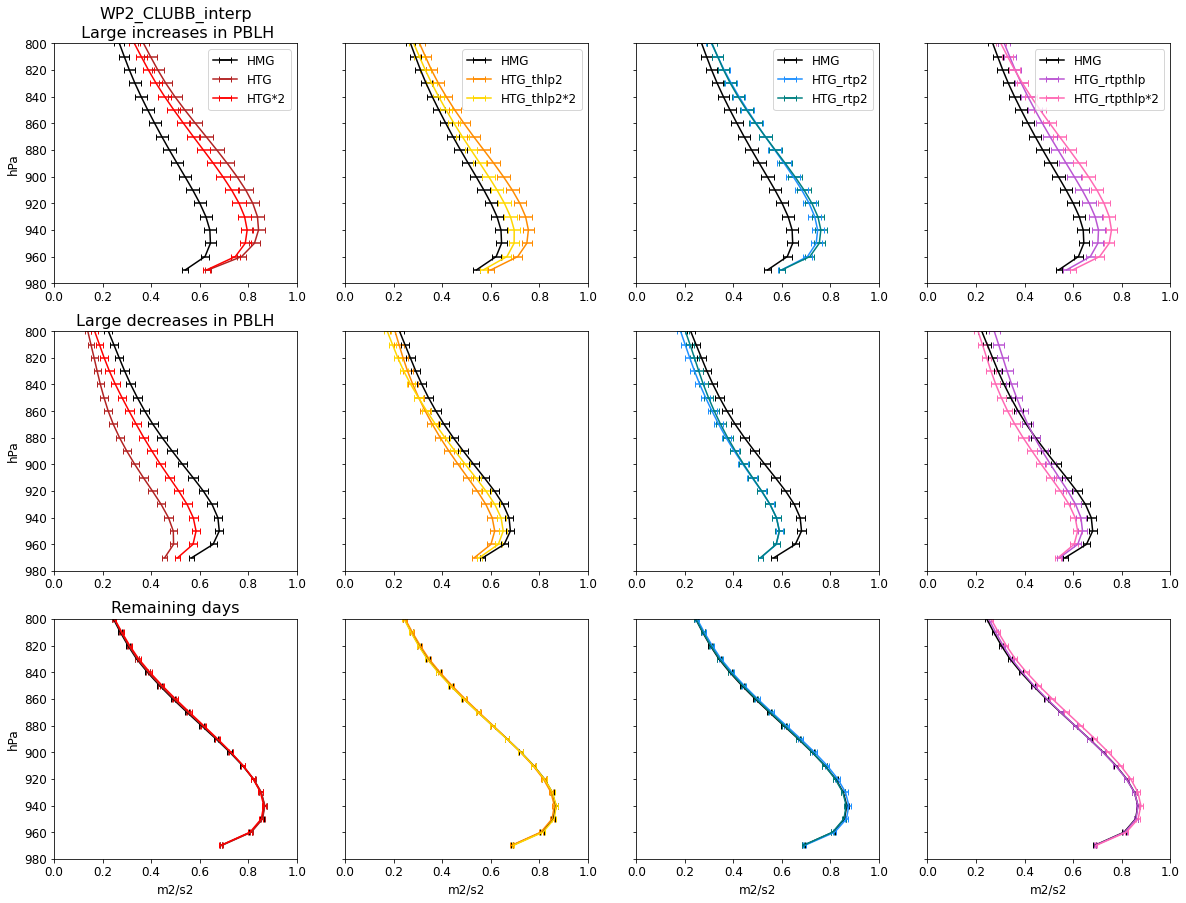

In [83]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'WP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           1.0,     # Max x value
                           800)     # Max level


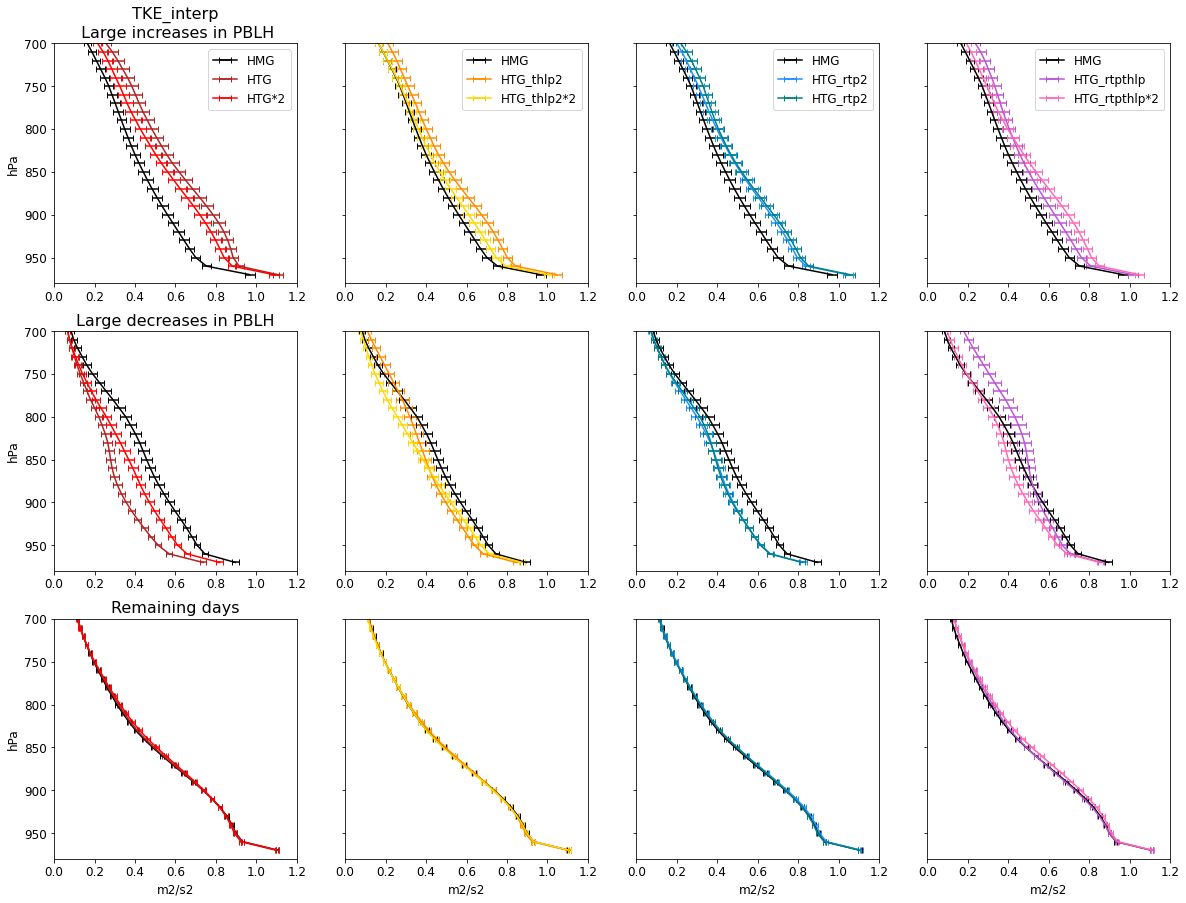

In [84]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'TKE_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           1.2,     # Max x value
                           700)     # Max level 


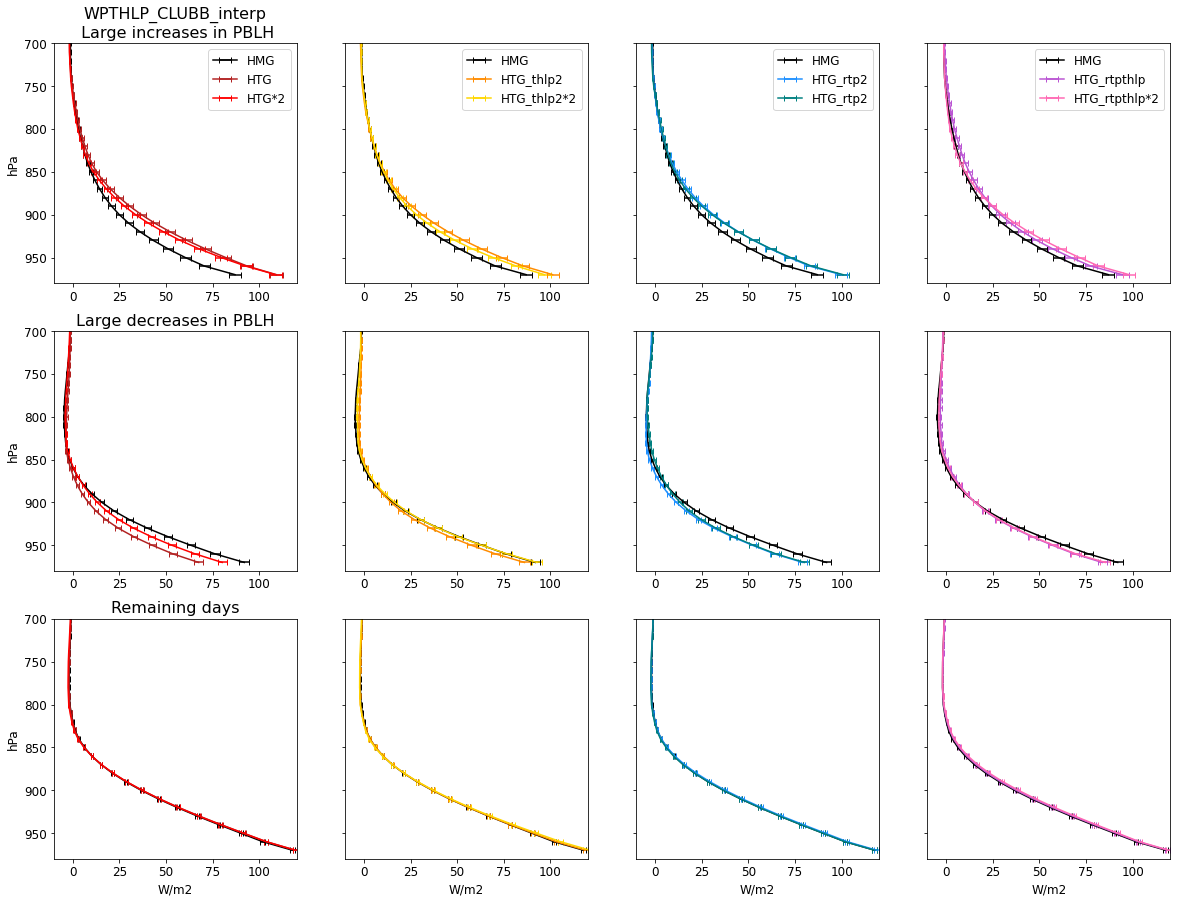

In [85]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'WPTHLP_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           -10,       # Min x value
                           120,     # Max x value
                           700)     # Max level 


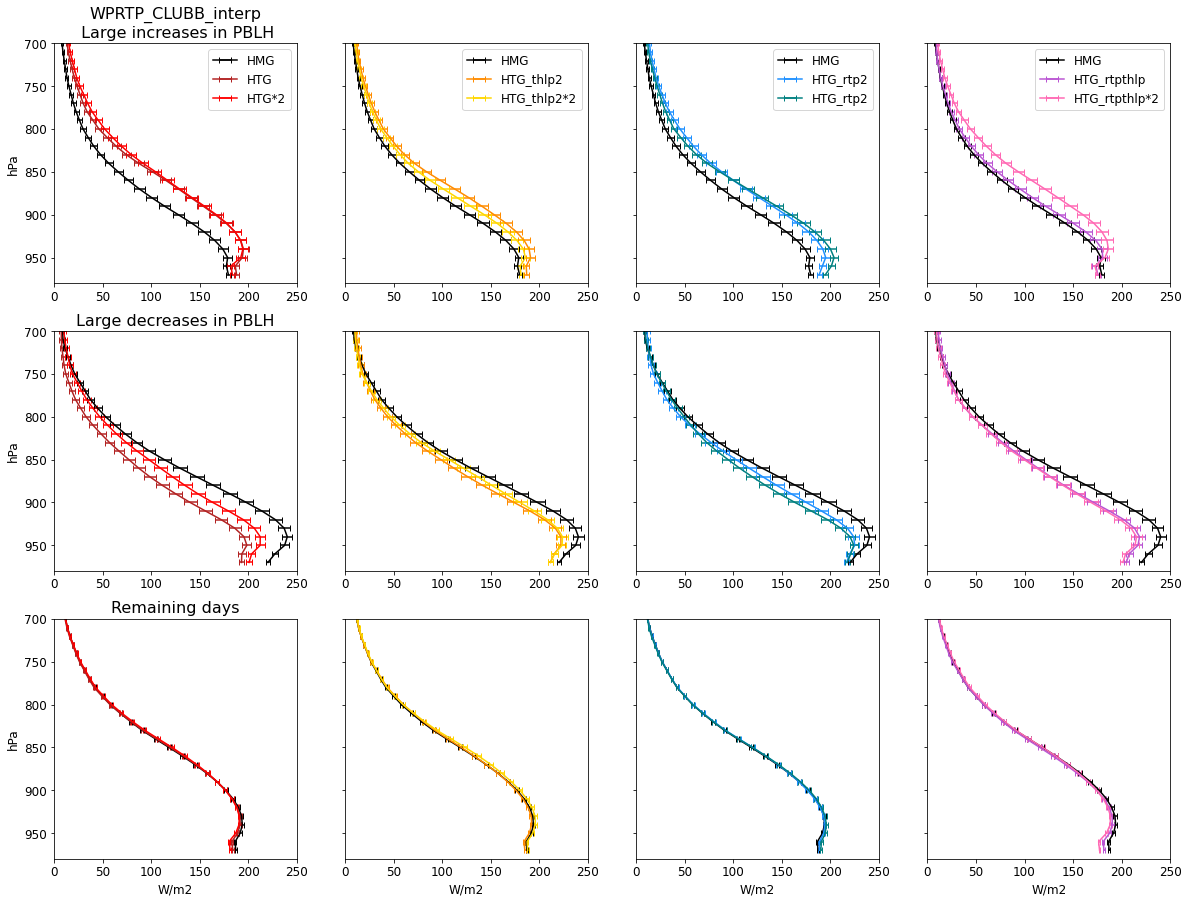

In [86]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'WPRTP_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           250,     # Max x value
                           700)     # Max level 


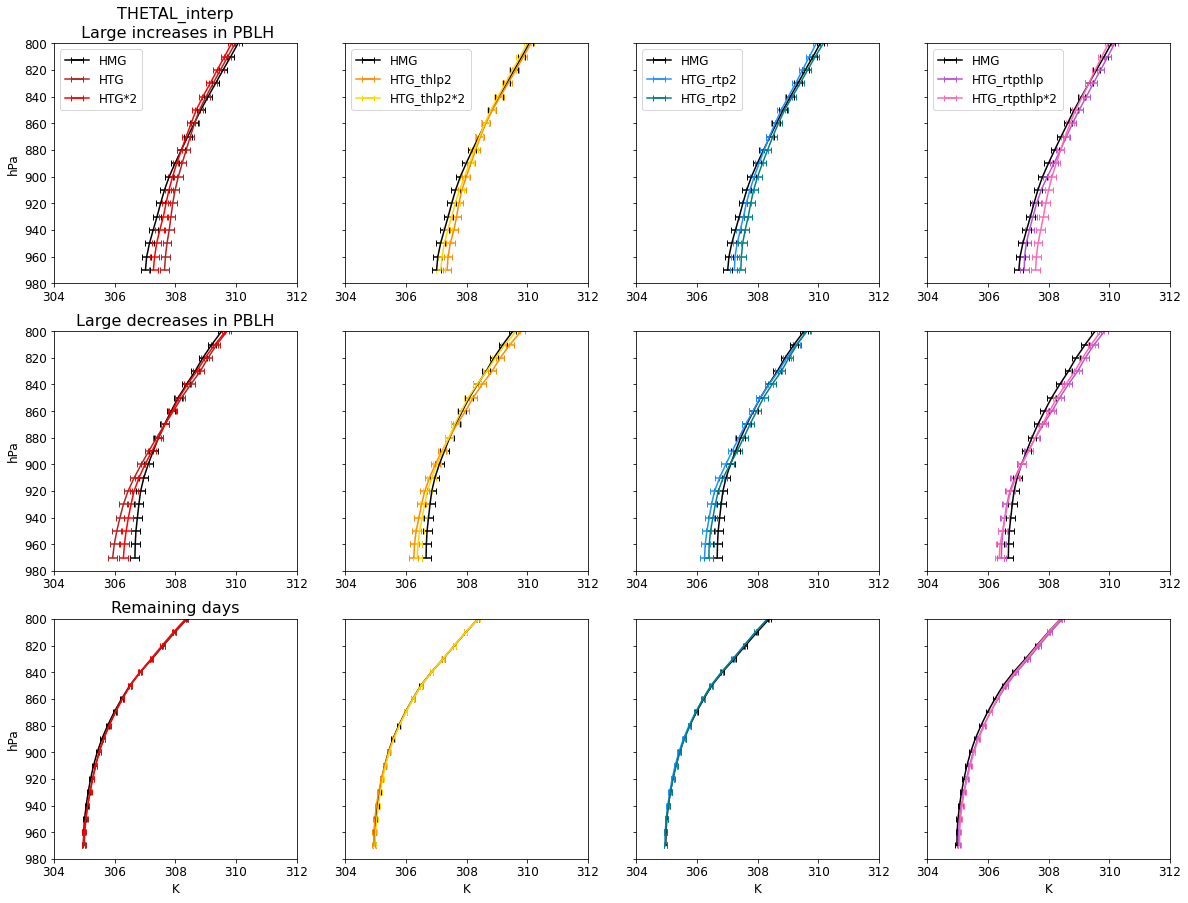

In [87]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'THETAL_interp',
                           12, 18,  # Start hr, end hr
                           304,     # Min x value
                           312,     # Max x value
                           800)     # Max level 


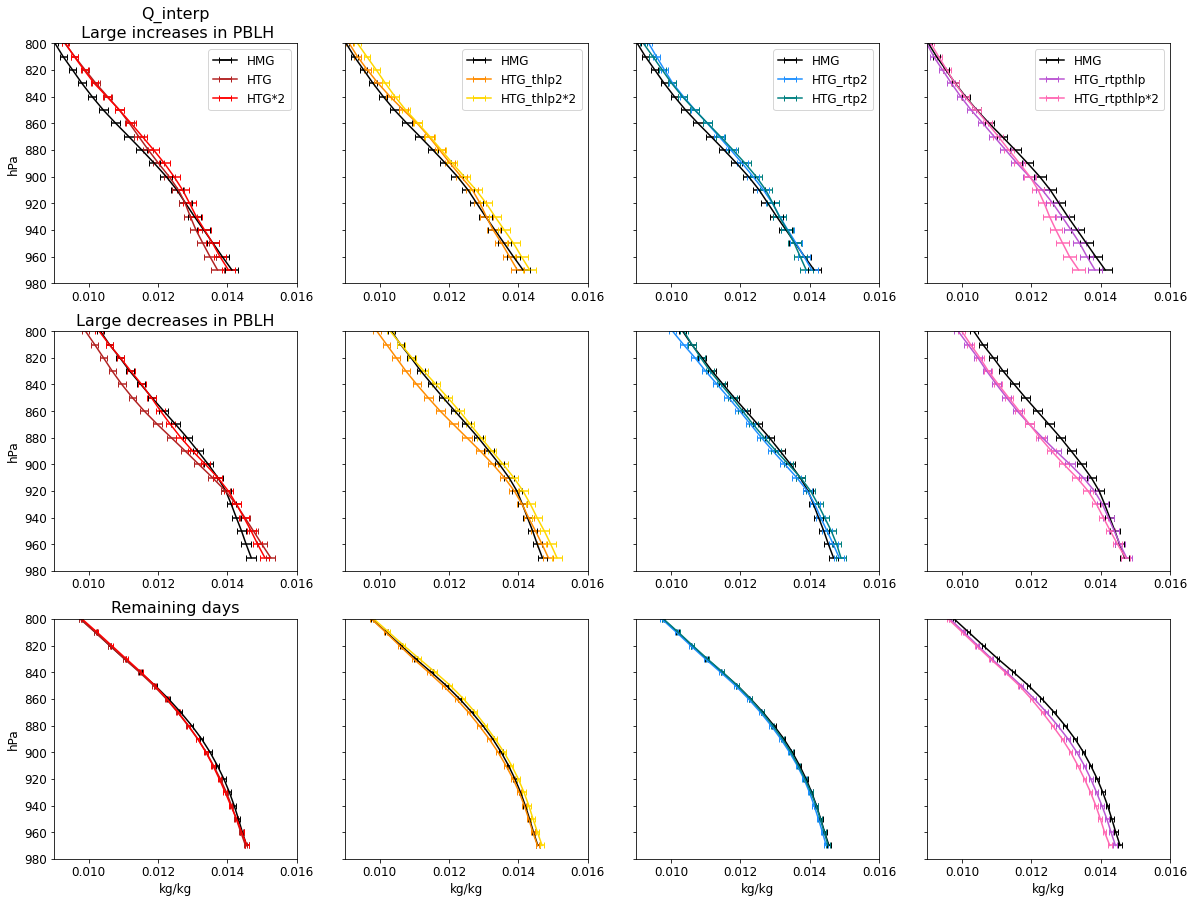

In [88]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'Q_interp',
                           12, 18,  # Start hr, end hr
                           0.009,     # Min x value
                           0.016,     # Max x value
                           800)     # Max level 


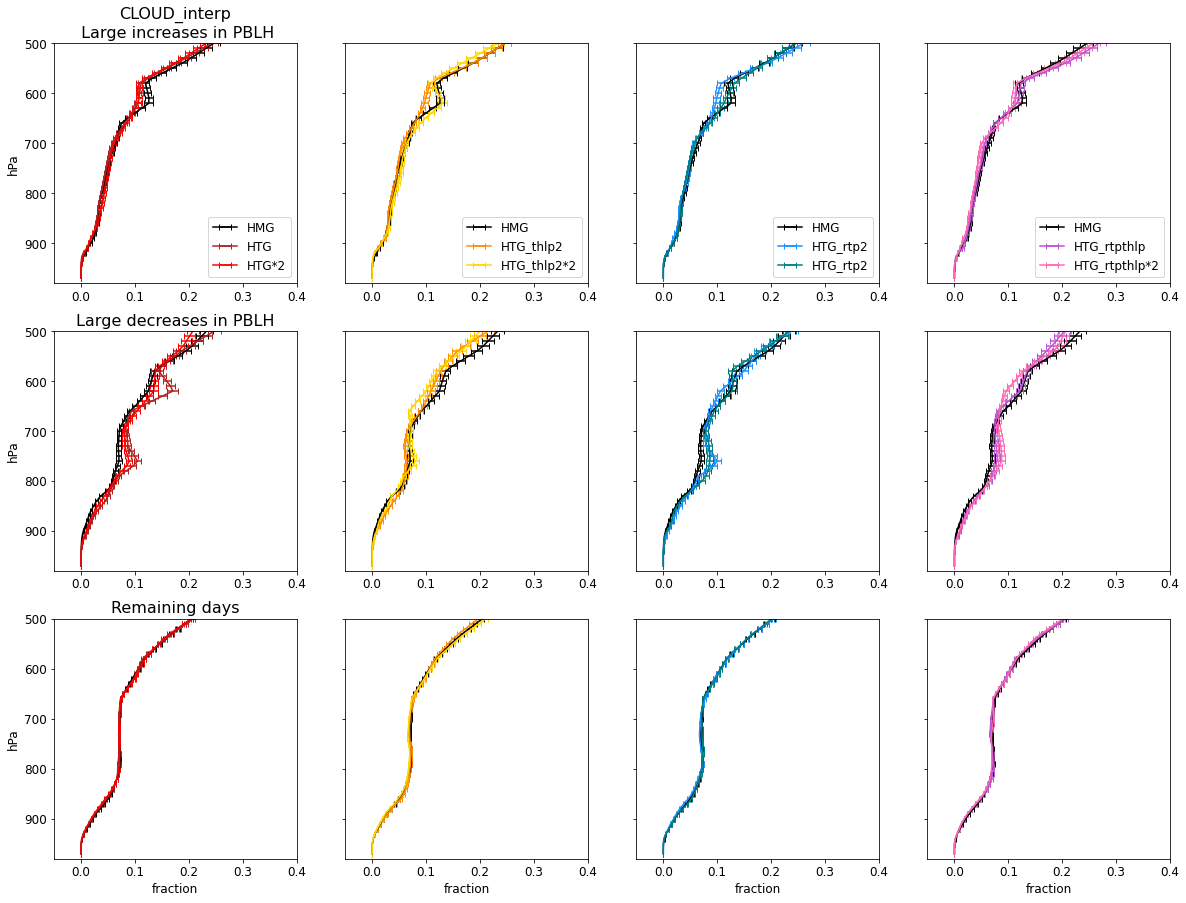

In [89]:
plotProfiles_meanOverHours_multipliers(highPct_realSfc, 
                           lowPct_realSfc, 
                           restOfDays_realSfc,
                          'CLOUD_interp',
                           12, 18,  # Start hr, end hr
                           -0.05,     # Min x value
                           0.4,     # Max x value
                           500)     # Max level 
